# Libraries

In [5]:
# Internal
from collections import namedtuple
from dataclasses import dataclass, field
import pickle

# Data
import pandas as pd
import numpy as np
import dill # pickle but for more complex objects (for saving the stats_dict which contains the custom OLS_Stats namedtuple)

# Graphing
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors

import cartopy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import FancyArrowPatch
from PIL import Image

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import seaborn as sns # for feature importances grid
from sklearn.metrics import PredictionErrorDisplay # For easy model qqplots in feature importances
from scipy.stats import probplot # Quick qqplot

Classes

In [6]:
coordinates = namedtuple("coordinates", ["lat", "lon"])

@dataclass
class Site_Data:
    elevation: int
    coords: coordinates = None
    sat_day: pd.DataFrame = field(default_factory = pd.DataFrame)
    sat_month: pd.DataFrame = field(default_factory = pd.DataFrame)
    sat_season: pd.DataFrame = field(default_factory = pd.DataFrame)
    sat_annual: pd.DataFrame = field(default_factory = pd.DataFrame)
    cli_day: pd.DataFrame = field(default_factory = pd.DataFrame)
    cli_month: pd.DataFrame = field(default_factory = pd.DataFrame)
    cli_season: pd.DataFrame = field(default_factory = pd.DataFrame)
    cli_annual: pd.DataFrame = field(default_factory = pd.DataFrame)

@dataclass
class Atmos_Data:
    day: pd.DataFrame = field(default_factory = pd.DataFrame)
    week: pd.DataFrame = field(default_factory = pd.DataFrame)
    month: pd.DataFrame = field(default_factory = pd.DataFrame)
    season: pd.DataFrame = field(default_factory = pd.DataFrame)
    annual: pd.DataFrame = field(default_factory = pd.DataFrame)

# Import

Import pickle files

In [7]:
with open("pkl/analysis_ready_sites.pkl", 'rb') as f:
    sites = pickle.load(f)

with open("pkl/density.pkl", 'rb') as f:
    density = pickle.load(f)

with open("pkl/stats.pkl", "rb") as f:
    stats_dict = dill.load(f)
    
with open("pkl/stats_combined.pkl", "rb") as f:
    stats_dict_all = dill.load(f)
    
with open("pkl/model_stats.pkl", 'rb') as f:
    model_stats = pickle.load(f)

Order the sites in the dictionaries

In [8]:
order = ["se_st1", "se_sto", "fi_ken", "fi_sod", "fi_var"]

res = dict()
for key in order:
    res[key] = sites[key]
sites = res

res = dict()
for key in order:
    res[key] = density[key]
density = res

res = dict()
for key in order:
    res[key] = stats_dict[key]
stats_dict = res

# Settings

## Aesthetics

In [9]:
# Fig scaling
scaler = 2
fig_wide = 6.267717 * scaler # width of a4 minus 2.54cm margins either side then x by scaler to scale everything"s size easily
fig_gold = 1.618

# Figure Saving
fig_path = "../figures/"
dpi = 300

aes = {
    "fluxnames": {
        "se_st1": "Abisko-Stordalen Grassland",
        "se_sto": "Abisko-Stordalen Palsa Mire",
        "fi_ken": "Kenttärova",
        "fi_sod": "Sodankylä",
        "fi_var": "Varrio",
    },
    "fluxnames_abv": {
        "se_st1": "Abisko-Sto. Grassland",
        "se_sto": "Abisko-Sto. Palsa Mire",
        "fi_ken": "Kenttärova",
        "fi_sod": "Sodankylä",
        "fi_var": "Varrio",
    },
    "pretty_platforms": {
        "MOD09GA": "MODIS Terra",
        "MYD09GA": "MODIS Aqua",
        "LT05": "Landsat 4",
        "LE07": "Landsat 7",
        "LC08": "Landsat 8",
        "S2_SR_HARMONIZED": "Sentinel-2",
        "LC09": "Landsat 9",
    },
    "colours": {
        "gppe": "limegreen",
        "gpp": "C0",
        "seasons": {
            "summer": "gold",
            "winter": "skyblue",
            "autumn": "coral",
            "spring": "lightgreen",
            "spring lag": "skyblue",
        },
        "ndvi": "teal",
    },
    "varnames": {
        "gppe": "GPPe",
        "gpp": "GPP",
        "ndvi": "NDVI",
        "temperature": "Temperature",
        "snowdepth": "Snowdepth",
    },
    "units": {
        "gppe": "(gCm$^{-2}$)",
        "gpp": "(gCm$^{-2}$)",
        "temperature": "($^o$C)",
        "snowdepth": "(cm)",
        "ao": "",
        "ndvi": ""
    },
}

## Functions

In [10]:
# Map Scalebar
def add_scalebar(ax, length, location = (0.1, 0.05), linewidth = 3, units = "km"):

    # Get axis limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # Convert relative location to data coordinates
    xdata = xlim[0] + location[0] * (xlim[1] - xlim[0])
    ydata = ylim[0] + location[1] * (ylim[1] - ylim[0])
    
    # Draw scale bar
    ax.plot([xdata, xdata + length], [ydata, ydata], color = "black", linewidth = linewidth)
    ax.text(xdata + length / 2, ydata + (ylim[1] - ylim[0]) * 0.01,
            f'{length} {units}', ha = "center", va = "bottom", fontsize = 9)


# Save Fig
def save_fig(fig, filename, fig_path = fig_path, dpi = dpi, bbox_inches_tight = True):
    fig.savefig(fig_path + f"fig_{filename}.svg", format = "svg", dpi = dpi, bbox_inches = "tight" if bbox_inches_tight == False else None)
    fig.savefig(fig_path + f"fig_{filename}.png", format = "png", dpi = dpi, bbox_inches = "tight" if bbox_inches_tight == False else None)


# Gen proportionate figure
def gen_fig(nrows, ncols, fig_wide = fig_wide, fig_gold = fig_gold, sharex = False, sharey = False, squish_factor = 1, constrained_layout = True, width_ratios = None, height_ratios = None, flatten_ax = True, subplot_kw = {}):
    fig, ax = plt.subplots(
        nrows = nrows, ncols = ncols, width_ratios = width_ratios, height_ratios = height_ratios,
        figsize = (fig_wide, (fig_wide / fig_gold) * ((nrows) / ncols) - squish_factor),
        sharex = sharex, sharey = sharey, constrained_layout = constrained_layout,
        subplot_kw = subplot_kw
    )
    if nrows * ncols > 1:
        if flatten_ax == True:
            ax = ax.flatten()
    
    return fig, ax


def format_no_leading_zero(value):
    formatted = f"{value:.2f}"
    if formatted.startswith("0"):
        return formatted[1:]
    elif formatted.startswith("-0"):
        return "-" + formatted[2:]
    else:
        return formatted


def write_stats(ax, row, col, name, name_idx = 0, global_y_offset = 0, ols = False, tskt = False):
    
    y_offset = 0.05 * name_idx

    significant = False  # Track significance
    
    # Make theil-sen/kendal tau text
    if tskt:
        ts_slope = f"{tskt[0]:.2f}"
        tau_val = f"{tskt[1]:.2f}"
        if tskt[2] < 0.05:
            ts_slope_text = rf"$\mathbf{{m={ts_slope}}}$"
            tskt_tau_text = rf"$\mathbf{{\tau={tau_val}}}$"
            tskt_p_text =  r"$\mathbf{p<.05}$"
            significant = True
        else:
            ts_slope_text = rf"$\mathrm{{m}}={ts_slope}$"
            tskt_tau_text = rf"$\tau={tau_val}$"
            tskt_p_text = rf"$p={format_no_leading_zero(tskt[2])}$"
        stats_text = f"{ts_slope_text}, {tskt_tau_text}, {tskt_p_text}"
        
    if ols:
        ols_r2 = f"{ols[0]:.2f}"
        ols_pval = f"{ols[1]:.2f}"
        if ols[1] < 0.05:
            ols_r2_text = rf"$\boldsymbol{{\mathbf{{adj.\,r^2}} = \mathbf{{{ols_r2}}}}}$"
            ols_p_text =  r"$\mathbf{p<.05}$"
            significant = True
        else:
            ols_r2_text = rf"$\mathrm{{adj.\,r^2}}={ols_r2}$"
            ols_p_text = rf"$p={format_no_leading_zero(ols[1])}$"
        stats_text = f"{ols_r2_text}, {ols_p_text}"
        
    # Make the series name bold if either lr or mk significant
    name_fmt = rf"$\mathbf{{{name}}}$" if significant else name
    
    # Final string
    full_text = f"{name_fmt}: {stats_text}"

    ax[row, col].text(
        x = 0.02, y = 0.93 - y_offset - global_y_offset,
        s = full_text,
        fontsize = 8, ha = "left", transform = ax[row, col].transAxes
    )


# Auto add outer legend
def add_outer_legend(fig, ax, ncol, markerscale = 2):
    
    # Make additional legend axis
    cbar_ax = fig.add_axes([0.25, -0.01, 0.5, 0])
    cbar_ax.axis('off')
    
    try:
        # Try to flatten ax and create dict of handles and labels
        flattened_ax = ax.flatten()
        handle_label_dict = {label: handle for axis in flattened_ax for handle, label in zip(*axis.get_legend_handles_labels())}
        handles, labels = handle_label_dict.values(), handle_label_dict.keys()
    except Exception as e:
        try:
            # Fallback to a specific axis
            handles, labels = ax[0].get_legend_handles_labels() # Change index as needed
        except Exception as e:
            # Fallback to a single axis
            handles, labels = ax.get_legend_handles_labels() # Change index as needed
    
    cbar_ax.legend(handles, labels, fontsize = 8, frameon = False, ncol = ncol, loc = "upper center", markerscale = markerscale)
    

# Convert feature names to nice looking versions
def prettify_feature_label(label: str) -> str:
    transformed = label
    
    # Append 'Day Lag' if 'lag_dir_' was present in the original
    if 'lag' in transformed:
        transformed = transformed.replace('lag', '')
        if 'dir' in transformed:
            transformed = transformed.replace('dir', 'Trend')
        transformed += ' Day Lag'
        
    # Apply capitalization rules
    if '_' in label:
        transformed = transformed.replace('__', ' ')
        transformed = transformed.replace('_', ' ')
        transformed = transformed.title()
    else:
        transformed = transformed.upper()

    # Replace specific substrings
    transformed = transformed.replace('Blue', 'Blue')
    transformed = transformed.replace('Green', 'Green')
    transformed = transformed.replace('Red', 'Red')
    transformed = transformed.replace('Nir', 'NIR')
    transformed = transformed.replace('Swir', 'SWIR')
    transformed = transformed.replace('Corr', 'Correlation')
    transformed = transformed.replace('Shade', 'Asymmetry')
    transformed = transformed.replace('Savg', 'Sum Average')
    transformed = transformed.replace('Idm', 'Homogeneity')
    transformed = transformed.replace('Sin', 'Sine')
    transformed = transformed.replace('Cos', 'Cosine')
    
    return transformed


# Sites Map

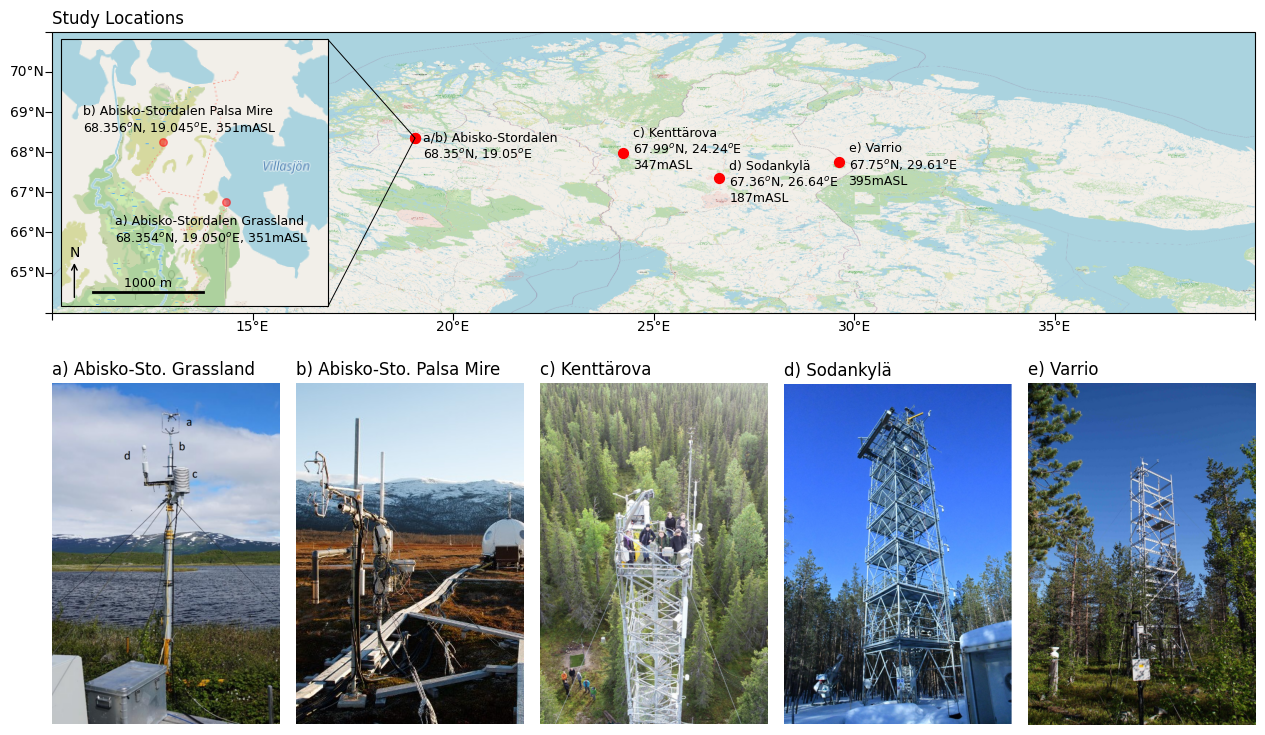

In [11]:
nrows = 2
ncols = 1
fig = plt.figure(figsize = (fig_wide, (fig_wide / fig_gold) * ((nrows) / ncols) - 8), layout = "constrained")
gs = gridspec.GridSpec(figure = fig, nrows = nrows, ncols = 5)

proj = ccrs.PlateCarree()#ccrs.LambertConformal(central_longitude=20, central_latitude=67, standard_parallels=(55, 70))#ccrs.TransverseMercator(central_longitude=20)# # 
tiler = cimgt.OSM()

# Map
ax1 = fig.add_subplot(gs[0, :], projection = proj)
ax1.set_title('Study Locations', loc = "left")
ax1.set_extent([12, 35, 64, 71], crs = proj)  # [west, east, south, north]
ax1.add_image(tiler, 8)

# Gridlines
gl = ax1.gridlines(draw_labels = True, dms = True, x_inline = False, y_inline = False)
gl.top_labels = False
gl.right_labels = False
gl.xlocator = plt.FixedLocator(range(10, 41, 5))  # Set x-ticks
gl.ylocator = plt.FixedLocator(range(64, 72, 1))  # Set y-ticks
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
gl.xlines = False # Hide gridlines
gl.ylines = False
xticks = np.arange(10, 41, 5) # tick marks
yticks = np.arange(64, 72, 1)
ax1.set_xticks(xticks, crs=proj) # Set tick posisitions
ax1.set_yticks(yticks, crs=proj)
ax1.tick_params(axis = "x", which = "both", direction = "out", length = 5, labelbottom = False, labelleft = False) # Enable ticks, set direction and length (outward)
ax1.tick_params(axis = "y", which = "both", direction = "out", length = 5, labelbottom = False, labelleft = False)

# Label offsetts
offsets = {
    "se_st1": (-0.009, -0.0012),
    "se_sto": (-0.0065, 0.0003),
    "fi_ken": (0.25, -0.4),
    "fi_sod": (0.25, -0.6),
    "fi_var": (0.25, -0.55),
}
for idx, (key, item) in enumerate(sites.items()):
    lon = item.coords.lon
    lat = item.coords.lat
    ax1.scatter(
        lon,
        lat,
        transform = proj,
        color = "red",
        s = 50
    )
    if idx > 1: # dont add abisko text as these go in the inset
        ax1.text(
            lon + offsets[key][0],
            lat + offsets[key][1],
            f"{chr(ord('`') + idx + 1)}) {aes["fluxnames"][key]}\n{item.coords[0]:.2f}$^o$N, {item.coords[1]:.2f}$^o$E\n{item.elevation}mASL",
            transform = proj,
            fontsize = 9,
            #fontweight = "bold",
            color = "k"
        )
    if idx == 0:
        ax1.text(
            lon + 0.2,
            lat + -0.5,
            f"a/b) Abisko-Stordalen\n{item.coords[0]:.2f}$^o$N, {item.coords[1]:.2f}$^o$E",
            transform = proj,
            fontsize = 9,
            #fontweight = "bold",
            color = "k"
        )

# Inset Map for Abisko
ax_inset = inset_axes(
    ax1,
    width = "22.5%",
    height = "95%",
    loc = "upper left",
    borderpad = 0.5,
    axes_class = cartopy.mpl.geoaxes.GeoAxes,
    axes_kwargs = dict(projection=tiler.crs)
)

site_lons = [sites[key].coords.lon for key in list(sites.keys())[:2]]
site_lats = [sites[key].coords.lat for key in list(sites.keys())[:2]]
ax_inset.add_image(tiler, 14)

lon_center = np.mean(site_lons) # Center
lat_center = np.mean(site_lats)
delta_lat = 0.008  # zoom
lat_rad = np.deg2rad(lat_center)
delta_lon = delta_lat / np.cos(lat_rad) # change lon according to zoom so we keep a square aspect ratio.
lon_min = lon_center - delta_lon / 2 # Calculate extent bounds
lon_max = lon_center + delta_lon / 2
lat_min = lat_center - delta_lat / 2
lat_max = lat_center + delta_lat / 2
ax_inset.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj) # Set extent on inset map

for idx, (key, item) in enumerate(list(sites.items())[:2]):
    lon = sites[key].coords.lon
    lat = sites[key].coords.lat
    ax_inset.scatter(lon, lat, color='red', s=30, alpha = 0.5, transform=proj, zorder=10)
    ax_inset.text(
        lon + offsets[key][0],
        lat + offsets[key][1],
        f"{chr(ord('`') + idx + 1)}) {aes["fluxnames"][key]}\n{item.coords[0]:.3f}$^o$N, {item.coords[1]:.3f}$^o$E, {item.elevation}mASL",
        fontsize=9,
        #fontweight='bold',
        color='k',
        transform=proj
    )
    
# North Arrow
arrow_lon = lon_min + 0.05 * delta_lon
arrow_lat_base = lat_min + 0.02 * delta_lat
arrow_lat_tip = arrow_lat_base + 0.0012
arrow = FancyArrowPatch(
    (arrow_lon, arrow_lat_base),
    (arrow_lon, arrow_lat_tip),
    transform = proj._as_mpl_transform(ax_inset),
    arrowstyle = "->",
    mutation_scale = 10,
    color = "black",
    linewidth = 1
)
ax_inset.add_patch(arrow)
ax_inset.text(
    arrow_lon,
    arrow_lat_tip + 0.00001,
    "N",
    ha = "center",
    va = "bottom",
    fontsize = 10,
    color = "black",
    transform = proj
)
add_scalebar(ax = ax_inset, length = 1000, location = (0.12, 0.05), linewidth = 2, units = 'm')

# Inset lines
st1_lon = sites["se_st1"].coords.lon
st1_lat = sites["se_st1"].coords.lat
ax1.annotate( # Top-right corner
    '',
    xy = (lon_max, lat_max - 0.000012),
    xycoords = proj._as_mpl_transform(ax_inset),
    xytext = (st1_lon, st1_lat),  # source: se_st1 point
    textcoords = proj._as_mpl_transform(ax1),
    arrowprops = dict(
        arrowstyle = "-",
        color = "black",
        linewidth = 0.7,
        shrinkA = 0,
        shrinkB = 0
    ),
    zorder = 150,
    annotation_clip = False
)
ax1.annotate( # Bottom-right corner
    '',
    xy = (lon_max, lat_min - 0.00004),
    xycoords = proj._as_mpl_transform(ax_inset),
    xytext = (st1_lon, st1_lat),  # source: se_st1 point
    textcoords = proj._as_mpl_transform(ax1),
    arrowprops = dict(
        arrowstyle = "-",
        color = "black",
        linewidth = 0.7,
        shrinkA = 0,
        shrinkB = 0
    ),
    zorder = 150,
    annotation_clip = False
)

# Pics row
image_paths = {
    "se_st1": "../data/raw/flux/abisko-stordalen-grassland/se_st1_site_image.png",
    "se_sto": "../data/raw/flux/abisko-stordalen-palsa-bog/se_sto_site_image.jpg",
    "fi_ken": "../data/raw/flux/kenttarova/fi_ken_site_image.png",
    "fi_sod": "../data/raw/flux/sodankyla/fi_sod_site_image.png",
    "fi_var": "../data/raw/flux/varrio/fi_var_site_image.png"
}
for idx, (key, item) in enumerate(sites.items()):
    ax = fig.add_subplot(gs[1, idx])
    img_path = image_paths.get(key)
    with Image.open(img_path) as img:
        ax.imshow(img, aspect = "equal")
    ax.set_title(f"{chr(ord('`') + idx + 1)}) {aes["fluxnames_abv"][key]}", loc = "left")
    ax.axis("off")
    
# Save
save_fig(fig, "locations")

# Data Density

se_st1: Mean total scenes per year = 146.25
se_sto: Mean total scenes per year = 162.75
fi_ken: Mean total scenes per year = 121.50
fi_sod: Mean total scenes per year = 153.88
fi_var: Mean total scenes per year = 153.50


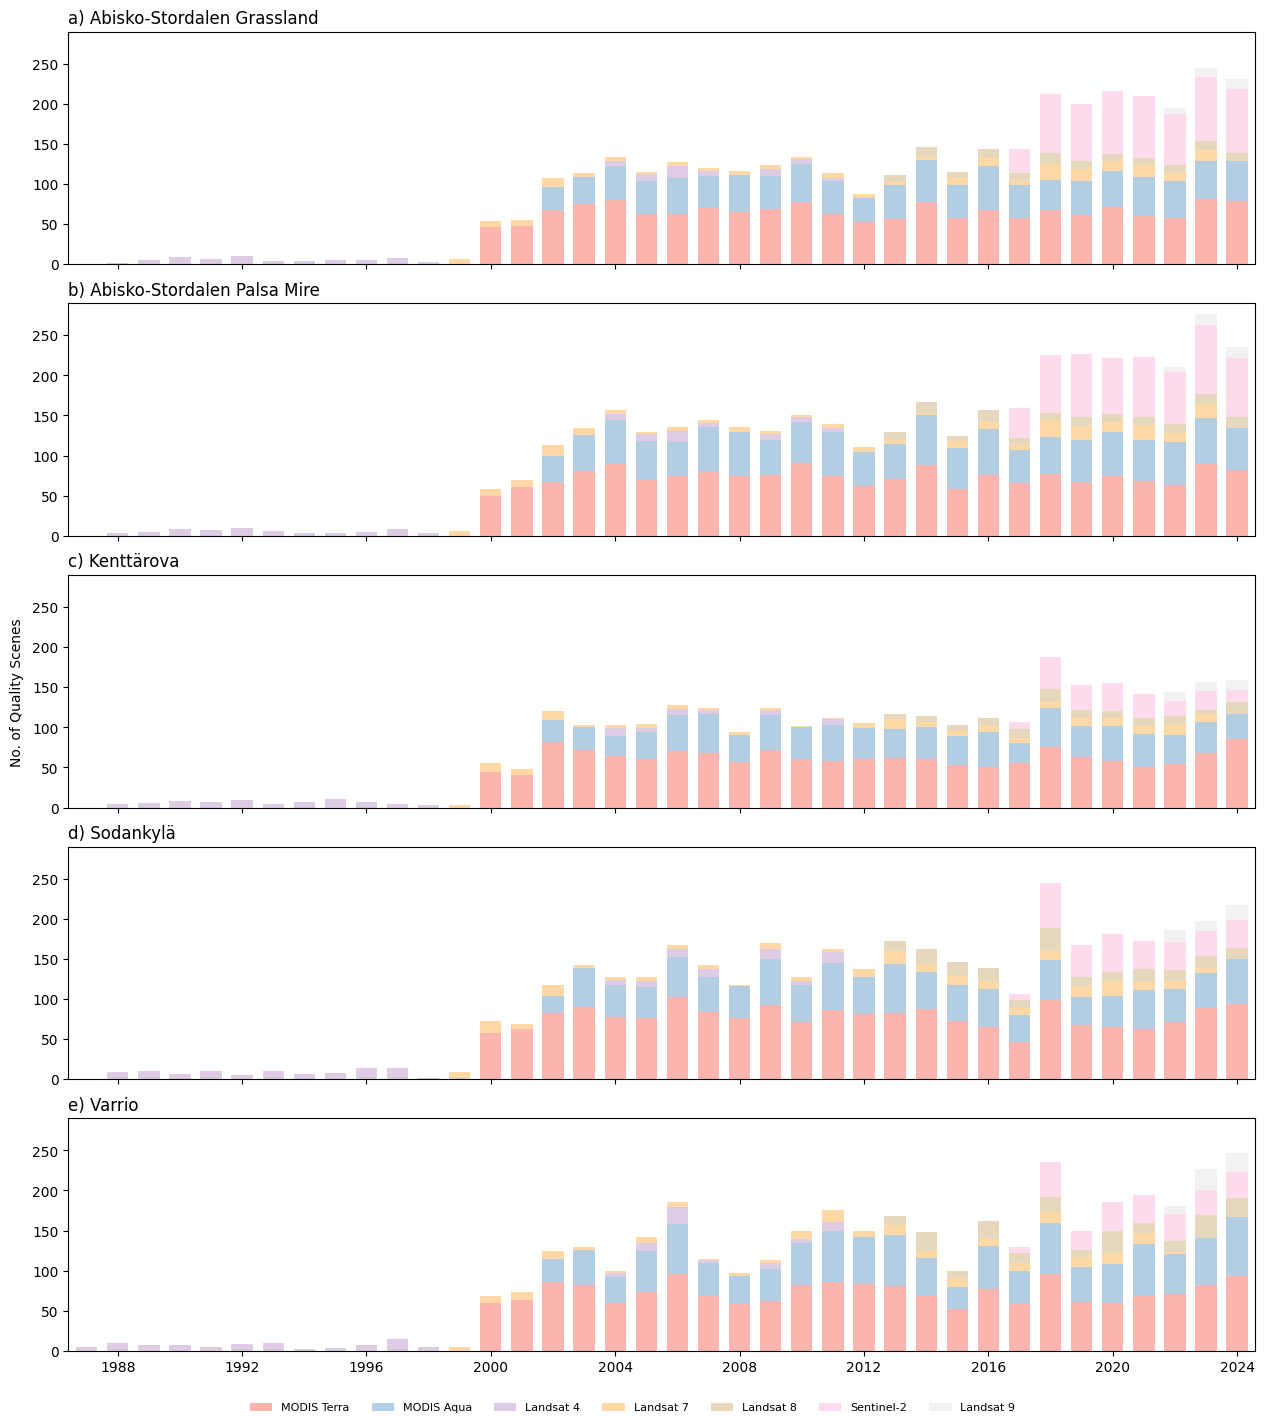

In [12]:
fig, ax = gen_fig(nrows = 5, ncols = 1, sharex = True, sharey = True, squish_factor = 25)

for idx, (key, items) in enumerate(density.items()):
    
    df = items.copy()
    df = df[df.index.year < 2025]
    df["year"] = df.index.year
    
    counts = df.groupby(["year", "platform_id"]).size().unstack(fill_value = 0)
    ordered_cols = [k for k in aes["pretty_platforms"] if k in counts.columns]
    counts = counts[ordered_cols]
    
    # Total counts per year across all platforms
    total_counts_per_year = counts.sum(axis = 1)
    total_counts_per_year = total_counts_per_year[total_counts_per_year.index > 2000]
    mean_total_count = total_counts_per_year.mean() # Mean total count over all years
    print(f"{key}: Mean total scenes per year = {mean_total_count:.2f}")

    # Convert year index to datetime (start of year)
    years = pd.to_datetime(counts.index, format = "%Y")

    num_platforms = counts.shape[1]
    cmap = mpl.colormaps["Pastel1"].resampled(num_platforms)
    colors = [mcolors.to_hex(cmap(i)) for i in range(num_platforms)]

    bottoms = np.zeros(len(years))

    # Plot stacked bars manually so we can have a continous x axis
    for i, platform in enumerate(counts.columns):
        ax[idx].bar(
            years, counts[platform], bottom = bottoms,
            width = pd.Timedelta(days = 250),
            color = colors[i], align = "center", label = platform
        )
        bottoms += counts[platform].values

    ax[idx].set_xlabel("")
    ax[idx].set_title(f"{chr(ord('`') + idx + 1)}) {aes["fluxnames"][key]}", loc = "left")

    if ax[idx].legend_:
        ax[idx].legend_.remove()

    ax[idx].set_xlim(pd.Timestamp("1986-06-01"), pd.Timestamp("2024-08-01"))
    #ax[idx].set_xticks(years)
    #ax[idx].set_xticklabels(years.year, rotation = 90)

fig.supylabel("No. of Quality Scenes", fontsize = 10)

# Legend
cbar_ax = fig.add_axes([0.25, -0.01, 0.5, 0])
cbar_ax.axis('off')
handles, labels = ax[idx].get_legend_handles_labels()
new_labels = [aes["pretty_platforms"].get(label, label) for label in labels]
cbar_ax.legend(handles, new_labels, fontsize = 8, frameon = False, ncol = 8, loc= "upper center")

# Save
save_fig(fig, "satellite_density")

# GPPe Overview

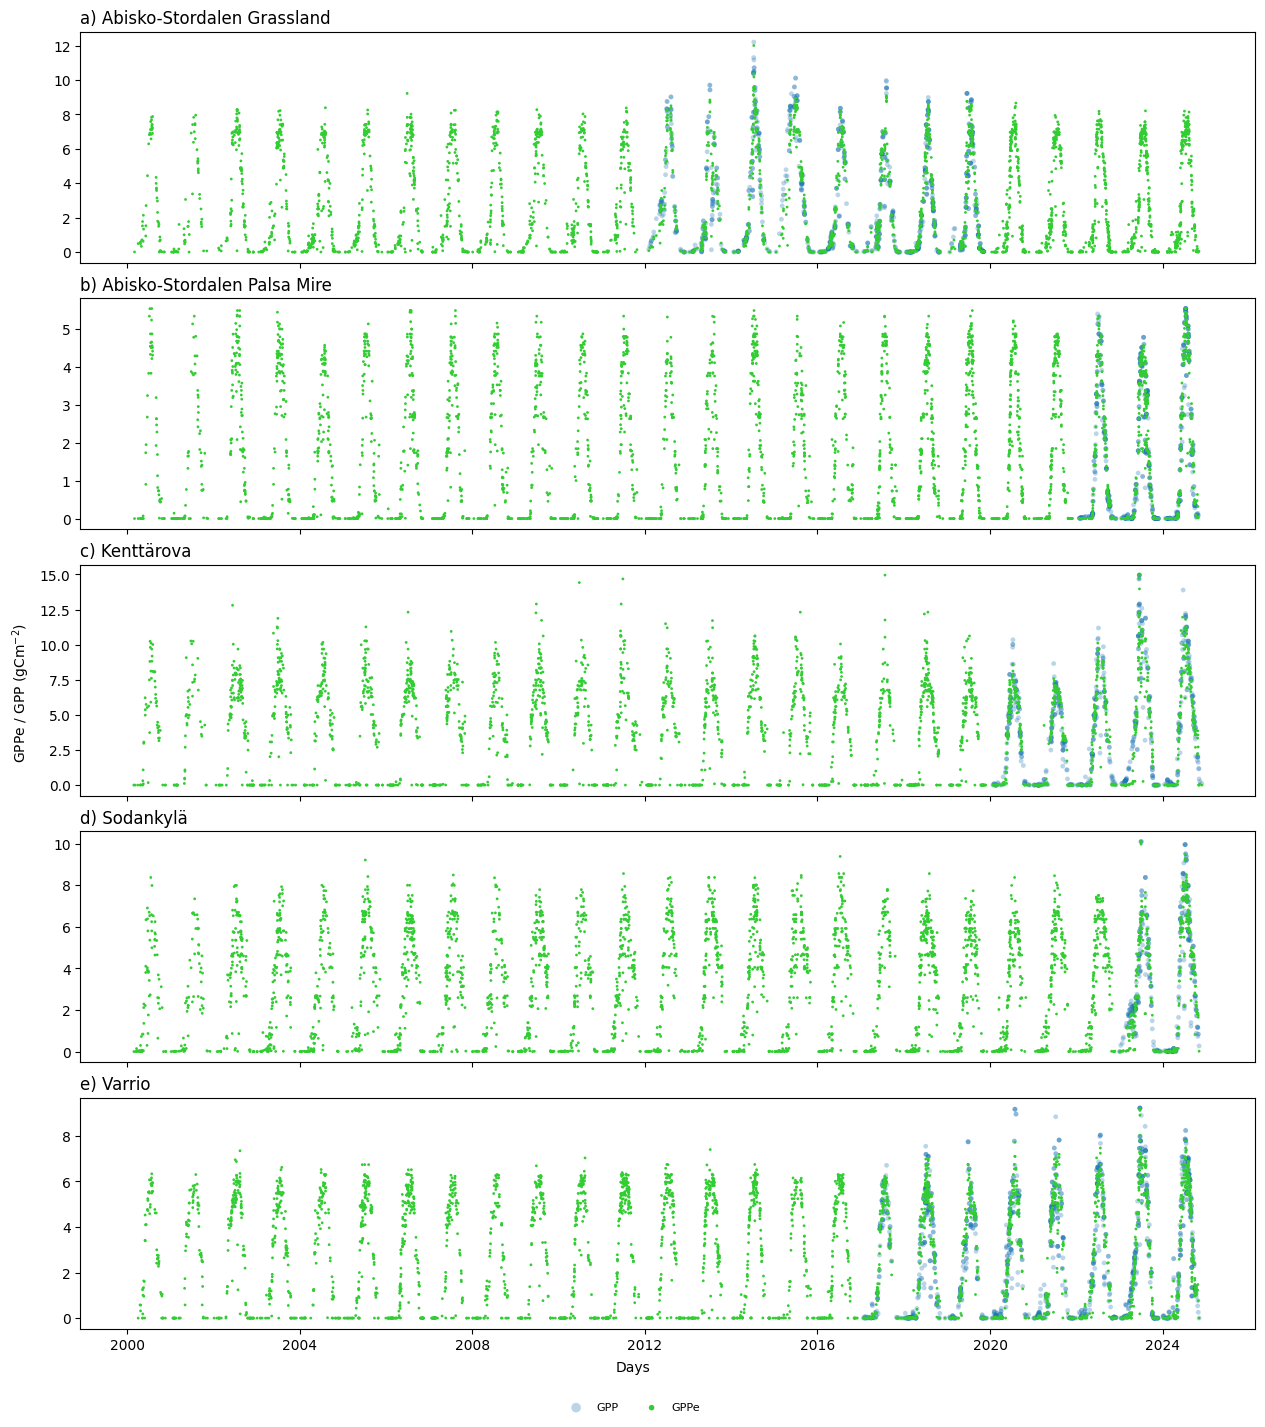

In [13]:
fig, ax = gen_fig(nrows = 5, ncols = 1, sharex = True, squish_factor = 25)

y_var1 = "gppe"
y_var2 = "gpp"

for idx, (key, items) in enumerate(sites.items()):
    
    # Get Data
    df = sites[key].sat_day
    
    # Scatter plot
    ax[idx].scatter(df.index, df[y_var2], c = aes["colours"][y_var2], s = 12, alpha = 0.3, label = aes["varnames"][y_var2], edgecolors = "none")
    ax[idx].scatter(df.index, df[y_var1], c = aes["colours"][y_var1], s = 4, alpha = 1, label = aes["varnames"][y_var1], edgecolors = "none")
    
    # Pane Title
    ax[idx].set_title(f"{chr(ord('`') + idx + 1)}) {aes['fluxnames'][key]}", loc = "left")
    
# Labels
fig.supylabel(f"{aes["varnames"][y_var1]} / {aes["varnames"][y_var2]} {aes["units"][y_var2]}", fontsize = 10)
fig.supxlabel(f"Days", fontsize = 10)

# Legend
add_outer_legend(fig = fig, ax = ax, ncol = 2, markerscale = 2)

# Save
save_fig(fig, "gppe-time_daily")

# GPPe Annual & Seasonal Through Time

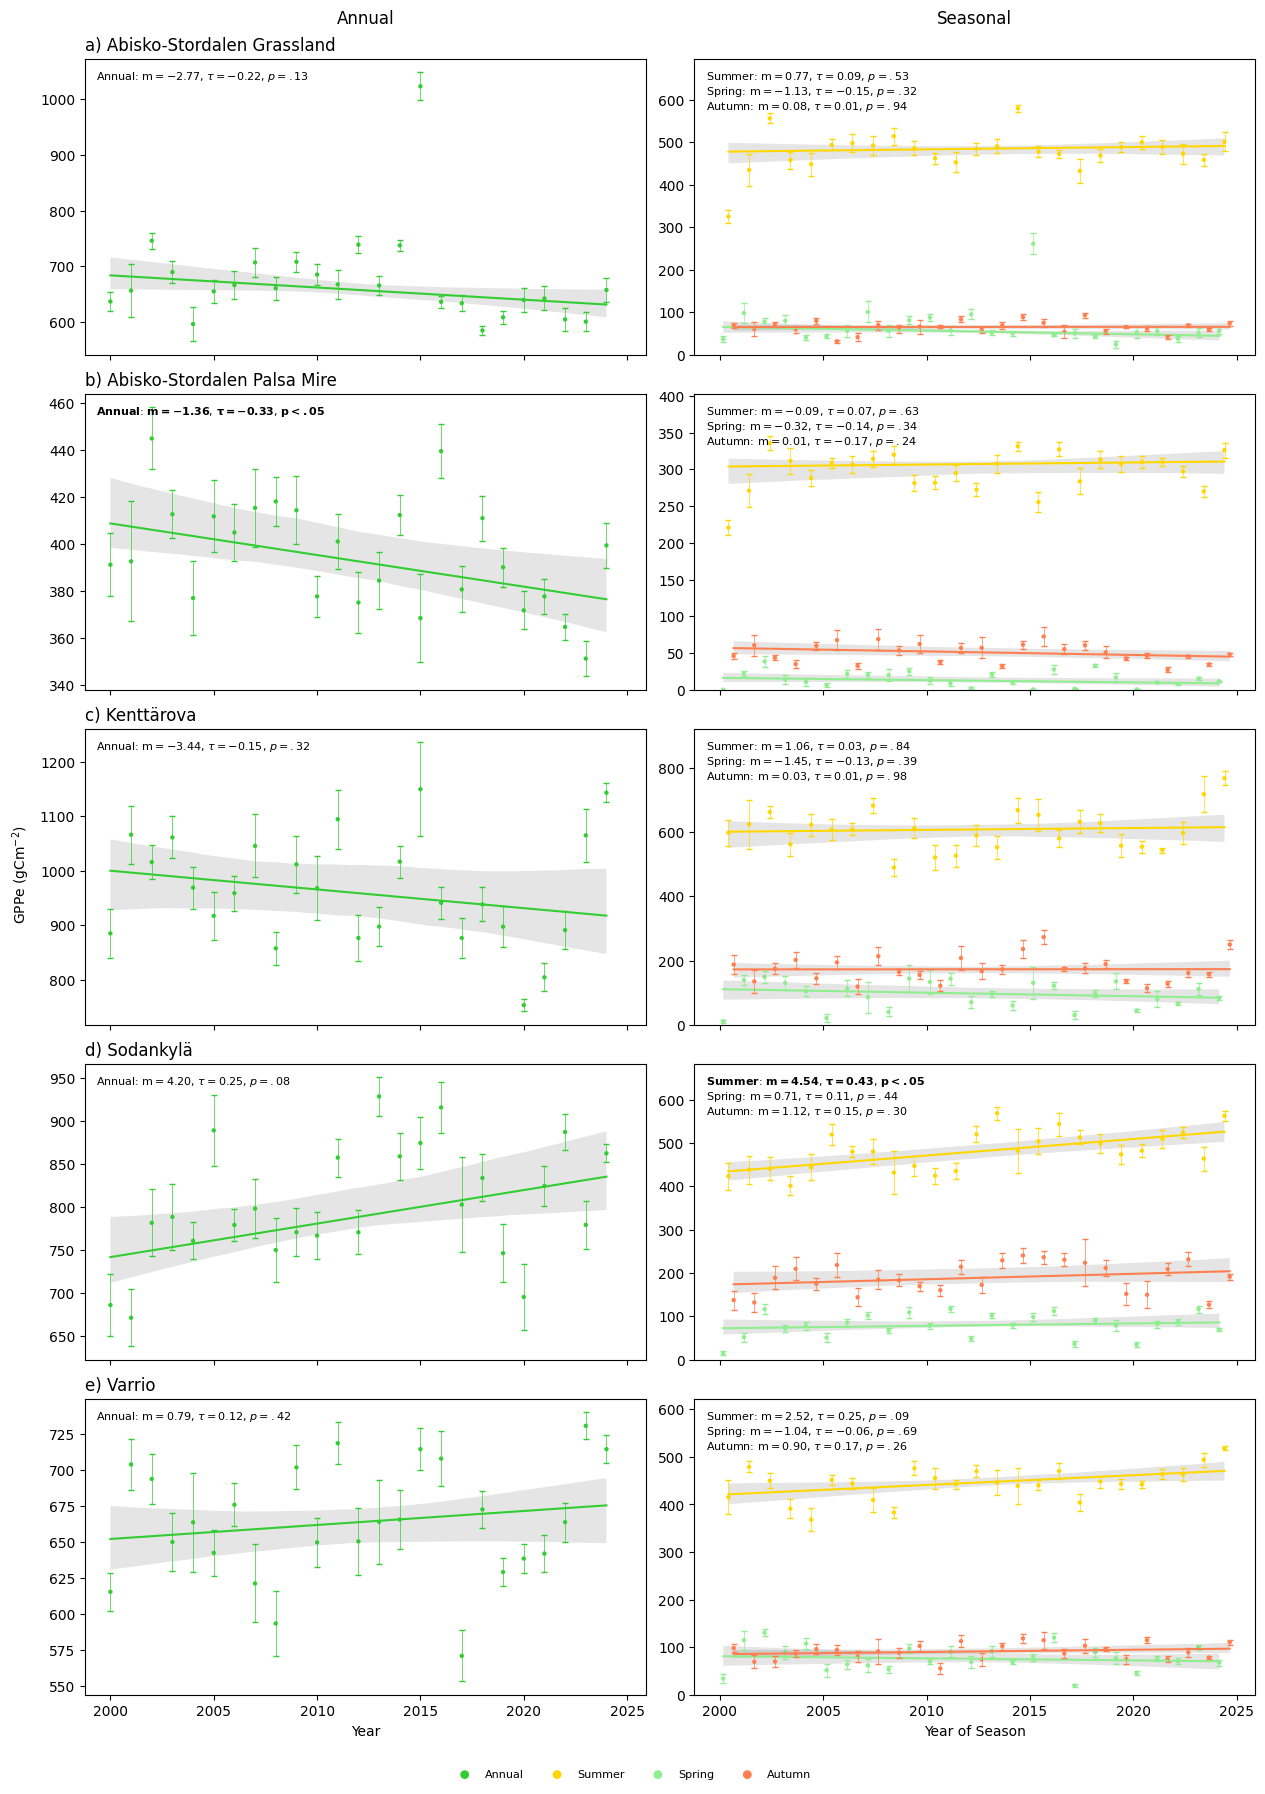

In [14]:
fig, ax = gen_fig(nrows = 5, ncols = 2, sharex = True, squish_factor = 2, flatten_ax = False)

# Left Column
test_name = "gppe-time_annual"
for idx, (key, entry) in enumerate(stats_dict.items()):
    
    # Get Test Data and Results
    item = entry[test_name]

    ts_slope = item["ts"].slope
    kt_tau = item["kt"].tau
    kt_pval = item["kt"].pval
    
    x_var = item["x_var"]
    y_var = item["y_var"]
    x = item["df"][item["x_var"]]
    y = item["df"][item["y_var"]]
    x_range = item["ts"].x_range
    y_pred = item["ts"].y_pred
    ci_lo = item["ts"].ci_lo
    ci_hi = item["ts"].ci_hi
    yerr = item["df"][item["y_var_std"]]
    
    # Plot
    ax[idx, 0].plot(
        x_range, y_pred,
        color = aes["colours"][y_var]
        )
    ax[idx, 0].fill_between(
        x_range.flatten(),
        ci_lo.flatten(), ci_hi.flatten(),
        color = "black", alpha = 0.1, edgecolor = "none"
    )
    ax[idx, 0].scatter(
        x, y,
        s = 10, edgecolor = "none",
        color = aes["colours"][y_var],
        label = "Annual"
        )
    ax[idx, 0].errorbar(
        x.squeeze(), y.squeeze(),
        yerr = yerr.squeeze(),
        fmt = "none",
        color = aes["colours"][y_var],
        elinewidth = 0.5, capsize = 2.5
    )
    
    # Stats Text
    write_stats(ax = ax, row = idx, col = 0, name = "Annual", tskt = (ts_slope, kt_tau, kt_pval))
    
    # Pane Title
    ax[idx, 0].set_title(f"{chr(ord('`') + idx + 1)}) {aes["fluxnames"][key]}", loc = "left")

# Right Column  
test_name = "gppe-time_season"
for idx, (key, entry) in enumerate(stats_dict.items()):
    ys = []
    for idx_season, (season, item) in enumerate(entry["gppe-time_season"].items()):
        
        # Get Test Data and Results
        ts_slope = item["ts"].slope
        kt_tau = item["kt"].tau
        kt_pval = item["kt"].pval
        
        x_var = item["x_var"]
        y_var = item["y_var"]
        x = item["df"][item["x_var"]]
        y = item["df"][item["y_var"]]
        x_range = item["ts"].x_range
        y_pred = item["ts"].y_pred
        ci_lo = item["ts"].ci_lo
        ci_hi = item["ts"].ci_hi
        yerr = item["df"][item["y_var_std"]]
        
        # Plot
        ax[idx, 1].plot(
            x_range, y_pred,
            color = aes["colours"]["seasons"][season]
            )
        ax[idx, 1].fill_between(
            x_range.flatten(),
            ci_lo.flatten(), ci_hi.flatten(),
            color = "black", alpha = 0.1, edgecolor = "none"
        )
        ax[idx, 1].scatter(
            x, y,
            s = 10, edgecolor = "none",
            color = aes["colours"]["seasons"][season],
            label = season.capitalize()
            )
        ax[idx, 1].errorbar(
            x.squeeze(), y.squeeze(),
            yerr = yerr.squeeze(),
            fmt = "none",
            elinewidth = 0.5, capsize = 2.5,
            color = aes["colours"]["seasons"][season]
        )
        
        # Stats Text
        write_stats(ax = ax, row = idx, col = 1, name = season.capitalize(), name_idx = idx_season, tskt = (ts_slope, kt_tau, kt_pval))
        
        # Collect y values from each season and....
        ys.append(y)
        
    # ...set ylim of all seasons to give space for stats text
    ax[idx][1].set_ylim(0, np.max(ys) + (np.max(ys)/5))
    
# Labels
fig.supylabel(f"{aes["varnames"][y_var]} {aes["units"][y_var]}", fontsize = 10) # just take the y_var from the last loop
ax[-1][0].set_xlabel("Year", fontsize = 10)
ax[-1][1].set_xlabel("Year of Season", fontsize = 10)
ax[0][0].text(x = 0.5, y = 1.12, s = "Annual", ha = "center", fontsize = 12, transform = ax[0][0].transAxes)
ax[0][1].text(x = 0.5, y = 1.12, s = "Seasonal", ha = "center", fontsize = 12, transform = ax[0][1].transAxes)

# Legend
add_outer_legend(fig = fig, ax = ax, ncol = 4)

# Save
save_fig(fig, "gppe-time_annual&seasonal", bbox_inches_tight = True)

# Feature Importances

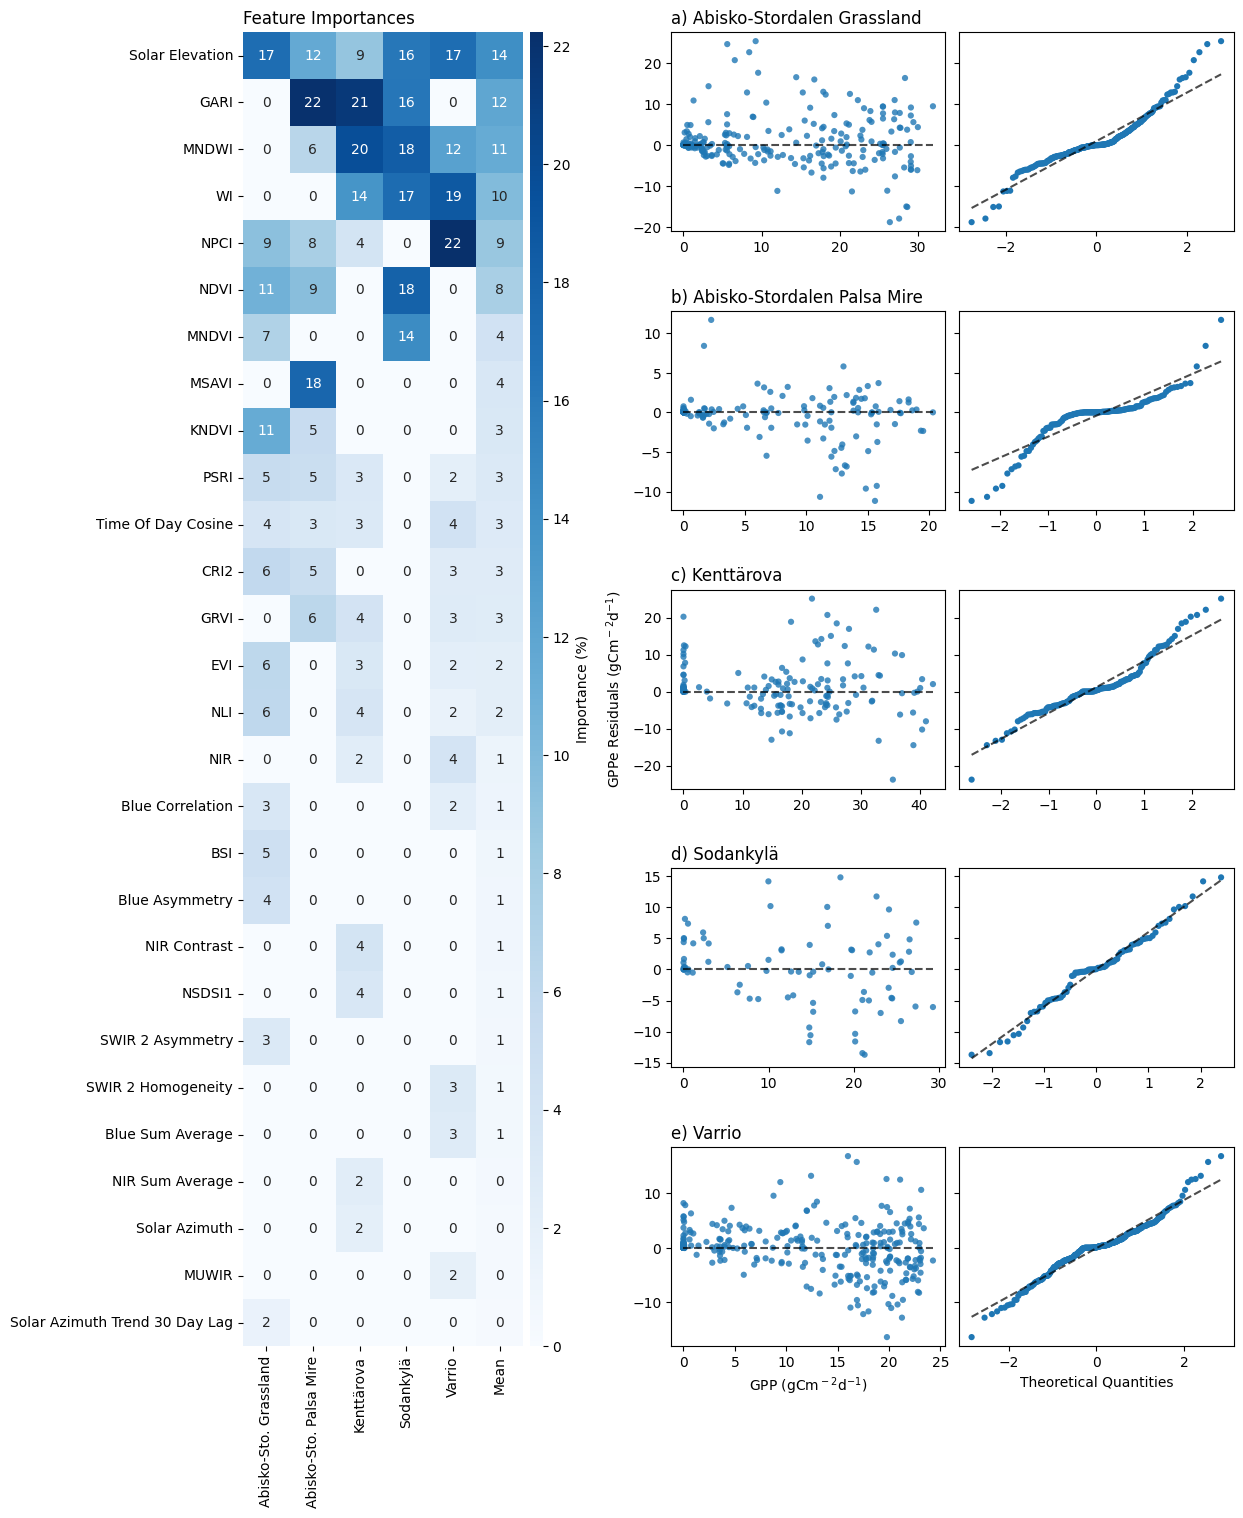

In [15]:
fig = plt.figure(figsize = (fig_wide, fig_wide * fig_gold- 5), layout = "tight")

gs_main = gridspec.GridSpec(1, 2, width_ratios = [0.6, 1], figure = fig) # Main gridspec with 1 row, 2 columns (left, right)
ax_left = fig.add_subplot(gs_main[0]) # Left col: single subplot spanning full height
gs_right = gridspec.GridSpecFromSubplotSpec(5, 1, subplot_spec = gs_main[1], hspace = 0.4) # Right col: subdivide into 5 rows
# For each of the 5 rows, create a nested gridspec with 2 rows (top and bottom subplot)
ax_right = []
for i in range(5):
    gs_right_i = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs_right[i], wspace = 0.05)
    ax_top = fig.add_subplot(gs_right_i[0])
    ax_bottom = fig.add_subplot(gs_right_i[1], sharey = ax_top)
    ax_right.append([ax_top, ax_bottom])

# Left col plot
# Get data
feature_importances = pd.concat([series["feature_importances"].rename(key) for key, series in model_stats.items()], axis = 1)
feature_importances["total"] = feature_importances.sum(axis = 1) / 5
feature_importances.replace(np.nan, 0, inplace = True)
feature_importances = feature_importances.sort_values(ascending = False, by = "total")

# Plot
sns.heatmap(
    feature_importances * 100,
    annot = True,
    fmt = ".0f",
    cmap = "Blues",
    cbar_kws = {
        "label": "Importance (%)",
        "shrink": 1,
        "aspect": 100,
        "pad": 0.02
        },
    linewidths = 0,
    ax = ax_left
)

ax_left.set_title("Feature Importances", loc = "left")

# Customize the colorbar ticks to show only round numbers
cbar = ax_left.collections[0].colorbar
ticks = np.arange(cbar.vmin, cbar.vmax, 2)
cbar.set_ticks(ticks)
cbar.set_ticklabels([str(int(t)) for t in ticks])

# Replace labels with nicer ones
current_features = [tick.get_text() for tick in ax_left.get_yticklabels()]
pretty_features = [prettify_feature_label(feature) for feature in current_features]
ax_left.set_yticklabels(pretty_features)
ax_left.set_xticklabels([name for _, name in aes["fluxnames_abv"].items()] + ["Mean"])
ax_left.tick_params(axis = "x", rotation = 90)
    
for idx, (key, items) in enumerate(model_stats.items()):

    # Get Data
    residuals = items["residuals"]
    y_pred_test = items["y_pred_test"]
    y_test = items["y_test"]

    # Right col plot
    # Top
    PredictionErrorDisplay.from_predictions(
        y_test,
        y_pred = y_pred_test,
        kind = "residual_vs_predicted",
        subsample = None,
        ax = ax_right[idx][0],
        random_state = 0,
        scatter_kwargs = {"edgecolors": "none", "s": 20}
    )
    if idx == 4:
        ax_right[idx][0].set_xlabel("GPP (gCm$^-$$^2$d$^{-1}$)")
    else:
        ax_right[idx][0].set_xlabel(None)
    
    if idx == 2:
        ax_right[idx][0].set_ylabel("GPPe Residuals (gCm$^-$$^2$d$^{-1}$)")
    else:
        ax_right[idx][0].set_ylabel(None)

    # Bottom
    #probplot(residuals, dist = "norm", plot = ax_right[idx][1])
    osm, osr = probplot(residuals, dist="norm", plot=None)[0]
    slope, intercept, r = probplot(residuals, dist="norm", plot=None)[1]
    ax_right[idx][1].scatter(osm, osr, color = "C0", edgecolors = "none", s = 20)  # scatter points in blue
    ax_right[idx][1].plot(osm, slope * osm + intercept, color='k', linestyle='--', alpha = 0.7)
    ax_right[idx][1].set_title(None)
    ax_right[idx][1].set_ylabel(None)
    if idx == 4:
        ax_right[idx][1].set_xlabel("Theoretical Quantities")
    else:
        ax_right[idx][1].set_xlabel(None)
    
    # Row Titles
    ax_right[idx][0].set_title(f"{chr(ord('`') + idx + 1)}) {aes['fluxnames'][key]}", loc = "left")
    
    # Labels
    ax_right[idx][1].tick_params(axis = "y", labelleft = False)

# Save
save_fig(fig, "model_evaluation")

# Phenologies

In [16]:
def create_custom_legend_handles(vars_, types, aes):

    legend_handles = []
    
    # Top-left empty cell
    legend_handles.append(Line2D([0], [0], color='none', label=''))
    
    # Column placeholders (empty handles for column headers)
    for _ in vars_:
        legend_handles.append(Line2D([0], [0], color='none', label=''))

    # Row-by-row: header placeholder + corresponding type handles
    for typ in types:
        legend_handles.append(Line2D([0], [0], color='none', label=''))  # Row header placeholder
        for var in vars_:
            c = aes["colours"][var]
            if typ == 'Day':
                handle = Line2D([0], [0], marker='o', color='none', markerfacecolor=c,
                                markersize=8, markeredgewidth=0, label='')
            elif typ == 'Mean':
                handle = Line2D([0], [0], color=c, linewidth=2, label='')
            elif typ == 'IQR':
                handle = Patch(facecolor=c, edgecolor='none', alpha=0.3, label='')
            else:
                raise ValueError(f"Unsupported type: {typ}")
            legend_handles.append(handle)

    return legend_handles

In [17]:
def add_custom_legend_labels(fig, ax, vars_, types, leg, col_label_map=None):
    ncols = len(vars_) + 1  # total columns in legend (including top-left empty)
    nrows = len(types) + 1  # total rows in legend

    bbox_fig = leg.get_window_extent().transformed(fig.transFigure.inverted())
    cell_width = bbox_fig.width / ncols
    cell_height = bbox_fig.height / nrows

    col_x_offset = 0.095
    row_y_offset = 0.075

    # Swap column headers: now types go on top
    for i, col_label in enumerate(types):
        x = bbox_fig.x0 + (i + 1) * cell_width + cell_width / 2 + col_x_offset
        y = bbox_fig.y1 + 0.08
        fig.text(x, y, col_label, ha='center', va='bottom', fontsize=9)

    # Swap row headers: now vars_ go on left
    for i, row_label in enumerate(vars_):
        display_name = col_label_map[row_label] if col_label_map and row_label in col_label_map else row_label.upper()
        x = bbox_fig.x0 + 0.125
        y = bbox_fig.y1 - (i + 1) * cell_height + cell_height / 2 + row_y_offset
        fig.text(x, y, display_name, ha='right', va='center', fontsize=9)

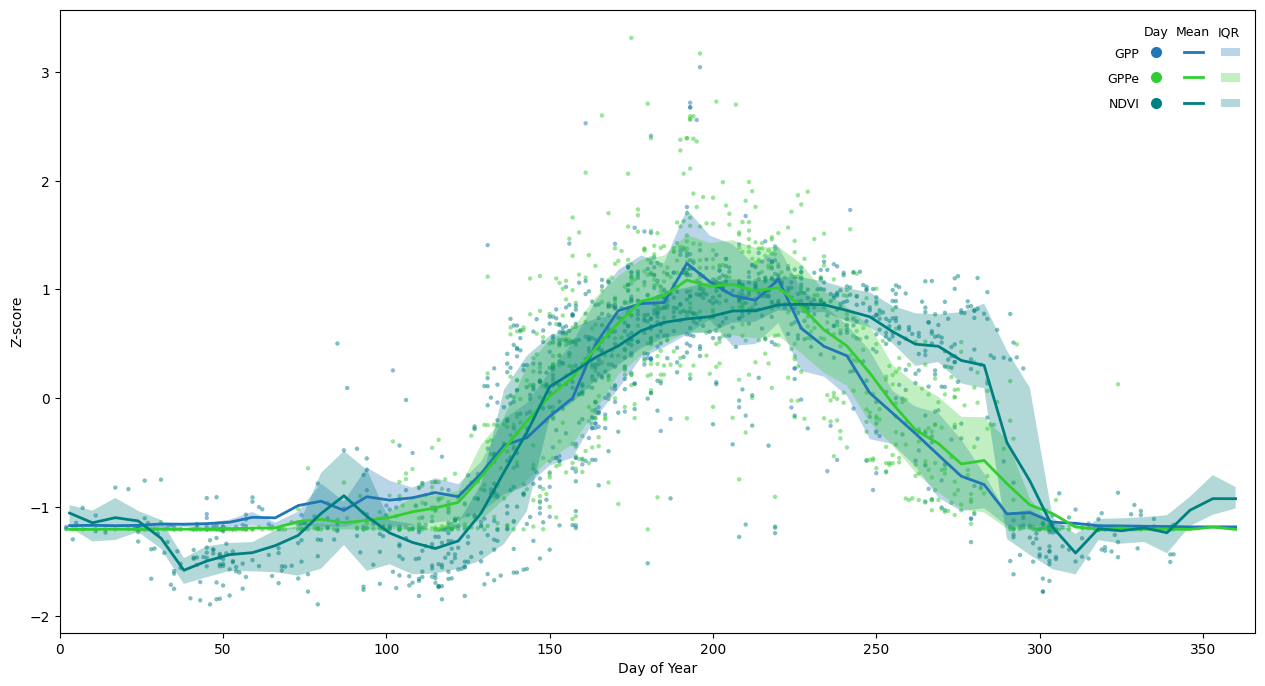

In [18]:
fig, ax = gen_fig(nrows = 1, ncols = 1)

for y_var in stats_dict_all["phenology"]["y_vars"]:
    
    # Get Daily Data
    series_day = stats_dict_all["phenology"]["df_day"][[y_var]]
    sample_day = series_day.sample(n = min(len(series_day), 1000), random_state = 2) # sample to avoid overplotting
    
    # Get Weekly Data
    series_week = stats_dict_all["phenology"]["df_week"][[y_var]]
    series_week = series_week.droplevel(0, axis = 1)
    
    # Draw
    ax.scatter(sample_day.index, sample_day[y_var], color = aes["colours"][y_var], s = 10, alpha = 0.5, edgecolors = "none", label = y_var, zorder = 1) # Daily dots
    ax.plot(series_week.index, series_week["mean"], color = aes["colours"][y_var], linewidth = 2, zorder = 3) # Mean
    #ax.plot(series_week.index, series_week["q25"], color = aes["colours"][y_var], linestyle = ":", linewidth = 2) # IQR 25
    #ax.plot(series_week.index, series_week["q75"], color = aes["colours"][y_var], linestyle = ":", linewidth = 2) # IQR 75
    ax.fill_between(series_week.index, series_week["q25"], series_week["q75"], color = aes["colours"][y_var], alpha = 0.3, edgecolors = "none", zorder = 2)

# Labels
ax.set_xlabel("Day of Year")
ax.set_ylabel("Z-score")
ax.set_xlim(0, 366)

# Legend
types = ['Day', 'Mean', 'IQR']
vars_ = ['gpp', 'gppe', 'ndvi']
col_label_map = {"gppe": "GPPe"}  # Pretty names
legend_handles = create_custom_legend_handles(vars_, types, aes) # Gen handles
leg = ax.legend( # Draw legend
    handles = legend_handles,
    loc = "upper right",
    frameon = False,
    fontsize = 9,
    ncol=len(vars_) + 1,
    handlelength = 1.5,
    handletextpad = 0.3,
    borderaxespad = 0.5,
    columnspacing = 1.2,
    labelspacing = 1.0
)
add_custom_legend_labels(fig, ax, vars_, types, leg, col_label_map) # Add row/column labels

# Save
save_fig(fig, "phenology")

In [19]:
def add_custom_legend_labels(fig, ax, vars_, types, leg, col_x_offset = 0, row_y_offset = 0, col_label_map = None):
    ncols = len(vars_) + 1  # including the empty top-left cell
    nrows = len(types) + 1  # including the empty top row for row headers

    bbox_fig = leg.get_window_extent().transformed(fig.transFigure.inverted())
    cell_width = bbox_fig.width / ncols
    cell_height = bbox_fig.height / nrows

    # Apply left offset by subtracting from x coordinates

    # Place types as column headers (top row, starting from second column)
    for i, col_label in enumerate(types):
        x = bbox_fig.x0 + (i + 1) * cell_width + cell_width - col_x_offset - 0.018
        y = bbox_fig.y1 + cell_height + 0.025
        fig.text(x, y, col_label, ha = "center", va = "bottom", fontsize = 9)

    # Place vars_ as row headers (left column, starting from second row)
    for i, row_label in enumerate(vars_):
        display_name = col_label_map[row_label] if col_label_map and row_label in col_label_map else row_label.upper()
        x = bbox_fig.x0 + cell_width * 0.9 - col_x_offset
        y = bbox_fig.y1 - (i + 1) * cell_height + cell_height + row_y_offset + 0.005
        fig.text(x, y, display_name, ha = "right", va = "center", fontsize = 9)


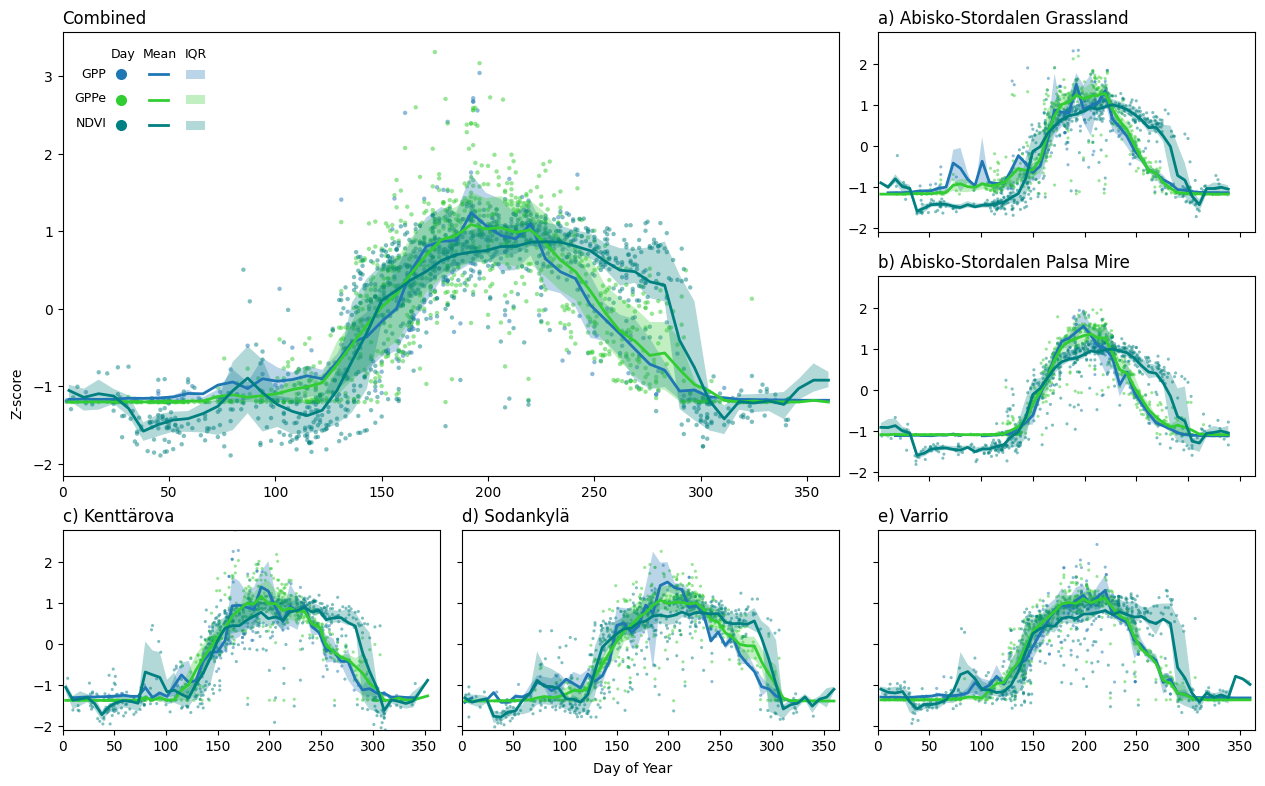

In [20]:
nrows = 3
ncols = 3
squish_factor = 0
fig = plt.figure(
    figsize = (fig_wide, (fig_wide / fig_gold) * ((nrows) / ncols) - squish_factor),
    layout = "constrained"
    )

# Big plot
ax_big = plt.subplot2grid((3, 3), (0, 0), rowspan = 2, colspan = 2)

# Small plots
ax_small3 = plt.subplot2grid((3, 3), (2, 0))
ax_small4 = plt.subplot2grid((3, 3), (2, 1))
ax_small1 = plt.subplot2grid((3, 3), (0, 2))
ax_small2 = plt.subplot2grid((3, 3), (1, 2))
ax_small5 = plt.subplot2grid((3, 3), (2, 2))
ax_small = [ax_small1, ax_small2, ax_small3, ax_small4, ax_small5]

# Draw on Big Plot
for y_var in stats_dict_all["phenology"]["y_vars"]:
    
    # Get Daily Data
    series_day = stats_dict_all["phenology"]["df_day"][[y_var]]
    sample_day = series_day.sample(n = min(len(series_day), 1000), random_state = 2) # sample to avoid overplotting
    
    # Get Weekly Data
    series_week = stats_dict_all["phenology"]["df_week"][[y_var]]
    series_week = series_week.droplevel(0, axis = 1)
    
    # Draw
    ax_big.scatter(sample_day.index, sample_day[y_var], color = aes["colours"][y_var], s = 10, alpha = 0.5, edgecolors = "none", label = y_var, zorder = 1) # Daily dots
    ax_big.plot(series_week.index, series_week["mean"], color = aes["colours"][y_var], linewidth = 2, zorder = 3) # Mean
    #ax_big.plot(series_week.index, series_week["q25"], color = aes["colours"][y_var], linestyle = ":", linewidth = 2) # IQR 25
    #ax_big.plot(series_week.index, series_week["q75"], color = aes["colours"][y_var], linestyle = ":", linewidth = 2) # IQR 75
    ax_big.fill_between(series_week.index, series_week["q25"], series_week["q75"], color = aes["colours"][y_var], alpha = 0.3, edgecolors = "none", zorder = 2)

# Axis
ax_big.set_xlim(0, 365)
ax_big.set_title(label = "Combined", loc = "left")

# Draw on Small Plots
ys = []
for idx, (key, entry) in enumerate(stats_dict.items()):
    
    ax = ax_small[idx]
    item = entry["phenology"]
    
    for y_var in item["y_vars"]:
    
        # Get Daily Data
        series_day = item["df_day"][[y_var]]
        sample_day = series_day.sample(n = min(len(series_day), 500), random_state = 2) # sample to avoid overplotting
        
        # Get Weekly Data
        series_week = item["df_week"][[y_var]]
        series_week = series_week.droplevel(0, axis = 1)
        
        # Draw
        ax.scatter(sample_day.index, sample_day[y_var], color = aes["colours"][y_var], s = 5, alpha = 0.5, edgecolors = "none", label = y_var, zorder = 1) # Daily dots
        ax.plot(series_week.index, series_week["mean"], color = aes["colours"][y_var], linewidth = 2, zorder = 3) # Mean
        #ax.plot(series_week.index, series_week["q25"], color = aes["colours"][y_var], linestyle = ":", linewidth = 2) # IQR 25
        #ax.plot(series_week.index, series_week["q75"], color = aes["colours"][y_var], linestyle = ":", linewidth = 2) # IQR 75
        ax.fill_between(series_week.index, series_week["q25"], series_week["q75"], color = aes["colours"][y_var], alpha = 0.3, edgecolors = "none", zorder = 2)
        
        ys.append(sample_day[y_var])

    # Axis
    ax.set_xlim(0, 365)
    if idx < 2:
        ax.set_xticklabels("")
    if idx > 2:
        ax.set_yticklabels("")
    
    # Pane Title
    ax.set_title(f"{chr(ord('`') + idx + 1)}) {aes['fluxnames'][key]}", loc = "left")

# Set global y min and y max for all small plots
for ax in ax_small:
    ax.set_ylim(np.nanmin(ys), np.nanmax(ys))

# Labels
fig.supxlabel("Day of Year", fontsize = 10)
fig.supylabel("Z-score", fontsize = 10)

# Legend
types = ['Day', 'Mean', 'IQR']
vars_ = ['gpp', 'gppe', 'ndvi']
col_label_map = {"gppe": "GPPe"}  # Pretty names
legend_handles = create_custom_legend_handles(vars_, types, aes) # Gen handles
leg = ax_big.legend( # Draw legend
    handles = legend_handles,
    loc = "upper left",
    frameon = False,
    fontsize = 9,
    ncol = len(vars_) + 1,
    handlelength = 1.5,
    handletextpad = 0.3,
    borderaxespad = 0.5,
    columnspacing = 1.2,
    labelspacing = 1.0
)
add_custom_legend_labels(fig, ax_big, vars_, types, leg, col_x_offset = 0.076, row_y_offset = 0.035, col_label_map = col_label_map)

# Save
save_fig(fig, "phenology_multi")

# Annual and Peak GPPe & NDVI Through Time

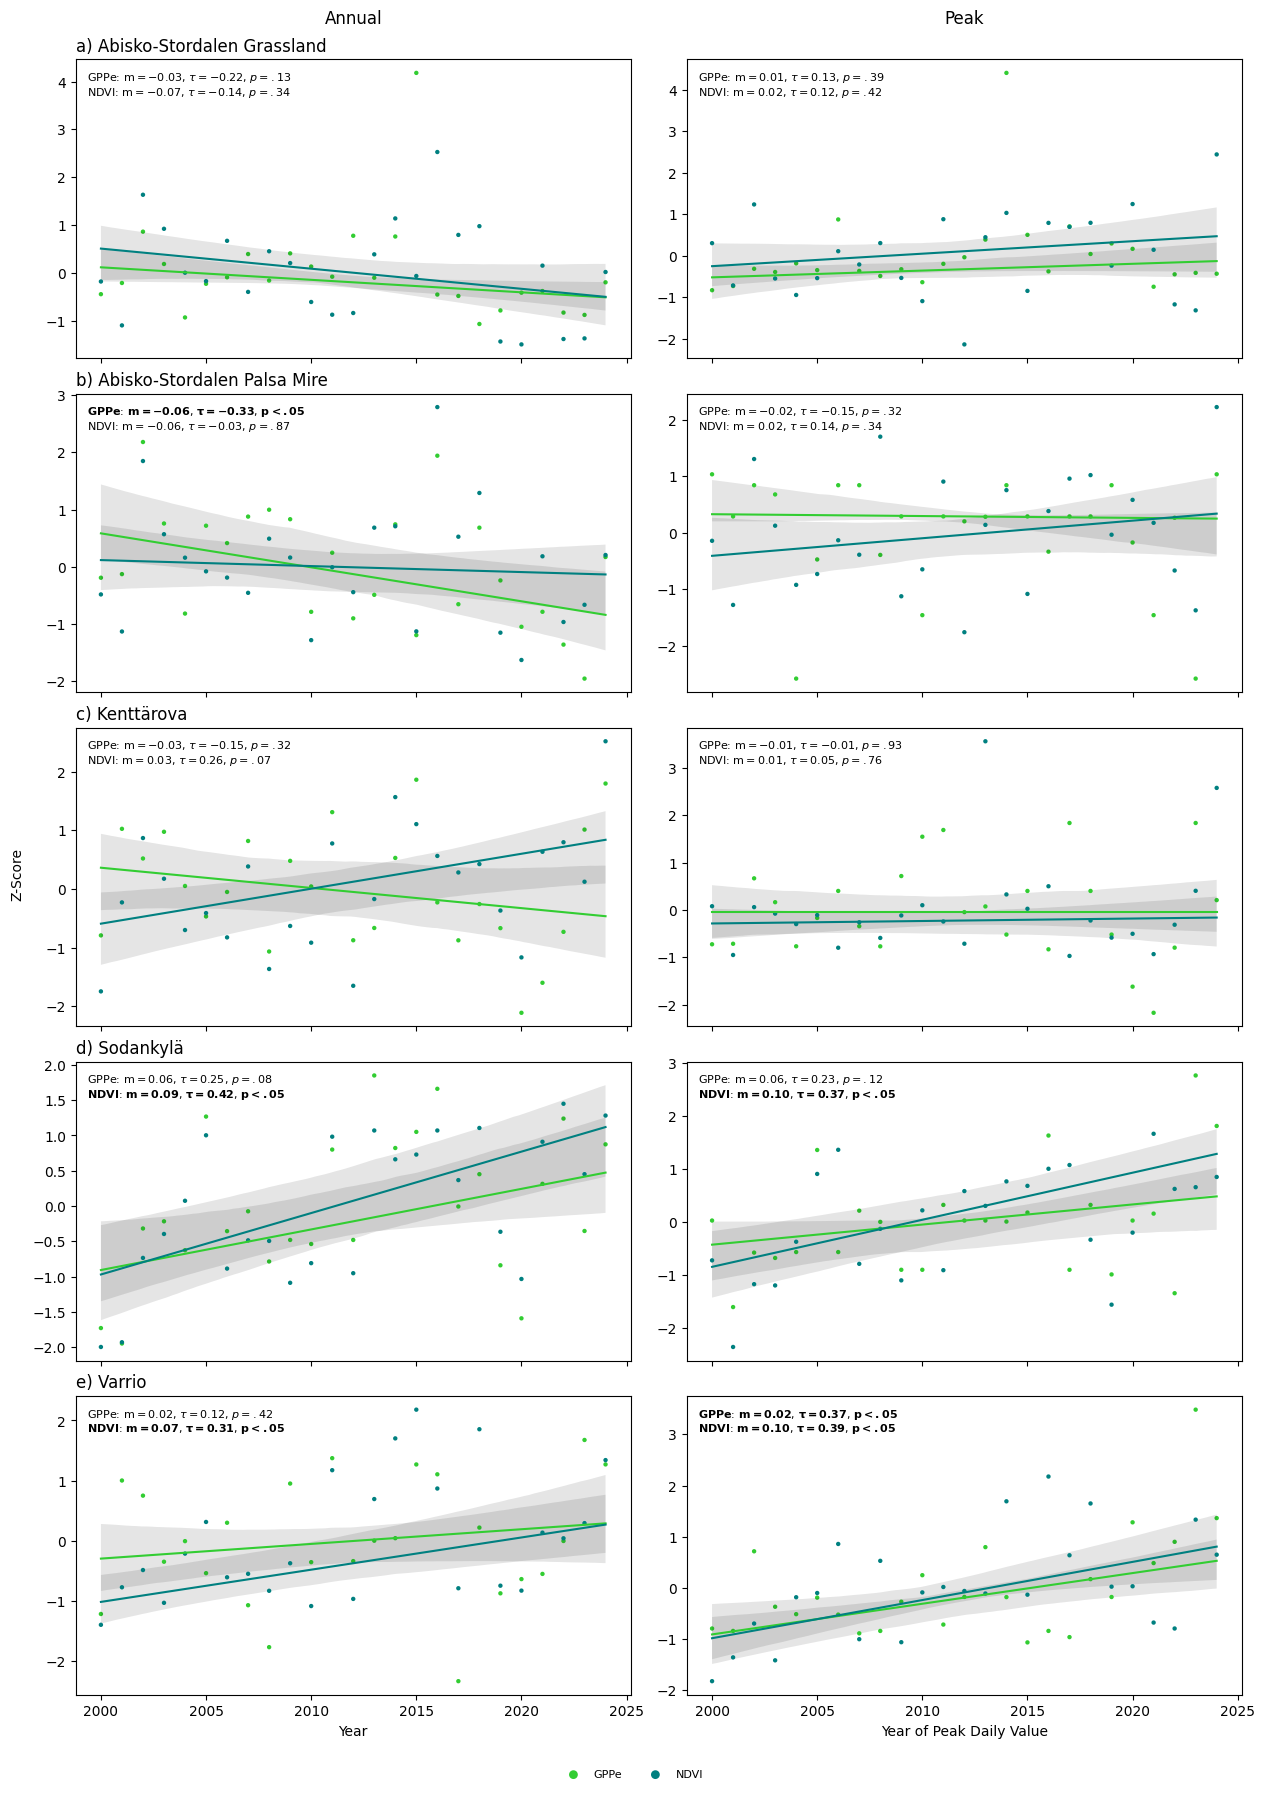

In [21]:
fig, ax = gen_fig(nrows = 5, ncols = 2, sharex = True, squish_factor = 2, flatten_ax = False)

# Left Column
test_name = "gppe_ndvi-time_annual"
for idx, (key, entry) in enumerate(stats_dict.items()):
    
    for idx_series, (series, item) in enumerate(entry[test_name].items()):
    
        # Get Test Data and Results
        ts_slope = item["ts"].slope
        kt_tau = item["kt"].tau
        kt_pval = item["kt"].pval
        
        x_var = item["x_var"]
        y_var = item["y_var"]
        x = item["df"][item["x_var"]]
        y = item["df"][item["y_var"]]
        x_range = item["ts"].x_range
        y_pred = item["ts"].y_pred
        ci_lo = item["ts"].ci_lo
        ci_hi = item["ts"].ci_hi
        
        # Plot
        ax[idx, 0].plot(
            x_range, y_pred,
            color = aes["colours"][y_var]
            )
        ax[idx, 0].fill_between(
            x_range.flatten(),
            ci_lo.flatten(), ci_hi.flatten(),
            color = "black", alpha = 0.1, edgecolor = "none"
        )
        ax[idx, 0].scatter(
            x, y,
            s = 10, edgecolor = "none",
            color = aes["colours"][y_var],
            label = aes["varnames"][y_var]
            )
        
        # Stats Text
        write_stats(ax = ax, row = idx, col = 0, name = aes["varnames"][y_var], name_idx = idx_series, tskt = (ts_slope, kt_tau, kt_pval))
    
    # Pane Title
    ax[idx, 0].set_title(f"{chr(ord('`') + idx + 1)}) {aes["fluxnames"][key]}", loc = "left")

# Right Column  
test_name = "gppe_ndvi-time_peak"
for idx, (key, entry) in enumerate(stats_dict.items()):
    
    for idx_series, (series, item) in enumerate(entry[test_name].items()):
    
        # Get Test Data and Results
        ts_slope = item["ts"].slope
        kt_tau = item["kt"].tau
        kt_pval = item["kt"].pval
        
        x_var = item["x_var"]
        y_var = item["y_var"]
        x = item["df"][item["x_var"]]
        y = item["df"][item["y_var"]]
        x_range = item["ts"].x_range
        y_pred = item["ts"].y_pred
        ci_lo = item["ts"].ci_lo
        ci_hi = item["ts"].ci_hi
        
        # Plot
        ax[idx, 1].plot(
            x_range, y_pred,
            color = aes["colours"][y_var]
            )
        ax[idx, 1].fill_between(
            x_range.flatten(),
            ci_lo.flatten(), ci_hi.flatten(),
            color = "black", alpha = 0.1, edgecolor = "none"
        )
        ax[idx, 1].scatter(
            x, y,
            s = 10, edgecolor = "none",
            color = aes["colours"][y_var],
            label = aes["varnames"][y_var]
            )
        
        # Stats Text
        write_stats(ax = ax, row = idx, col = 1, name = aes["varnames"][y_var], name_idx = idx_series, tskt = (ts_slope, kt_tau, kt_pval))
    
# Labels
fig.supylabel(f"Z-Score", fontsize = 10) # just take the y_var from the last loop
ax[-1][0].set_xlabel("Year", fontsize = 10)
ax[-1][1].set_xlabel(f"Year of Peak Daily Value", fontsize = 10)
ax[0][0].text(x = 0.5, y = 1.12, s = "Annual", ha = "center", fontsize = 12, transform = ax[0][0].transAxes)
ax[0][1].text(x = 0.5, y = 1.12, s = "Peak", ha = "center", fontsize = 12, transform = ax[0][1].transAxes)

# Legend
add_outer_legend(fig = fig, ax = ax, ncol = 2)

# Save
save_fig(fig, "gppe&ndvi-time_annual&peak", bbox_inches_tight = True)

# GPPe Over Temperature

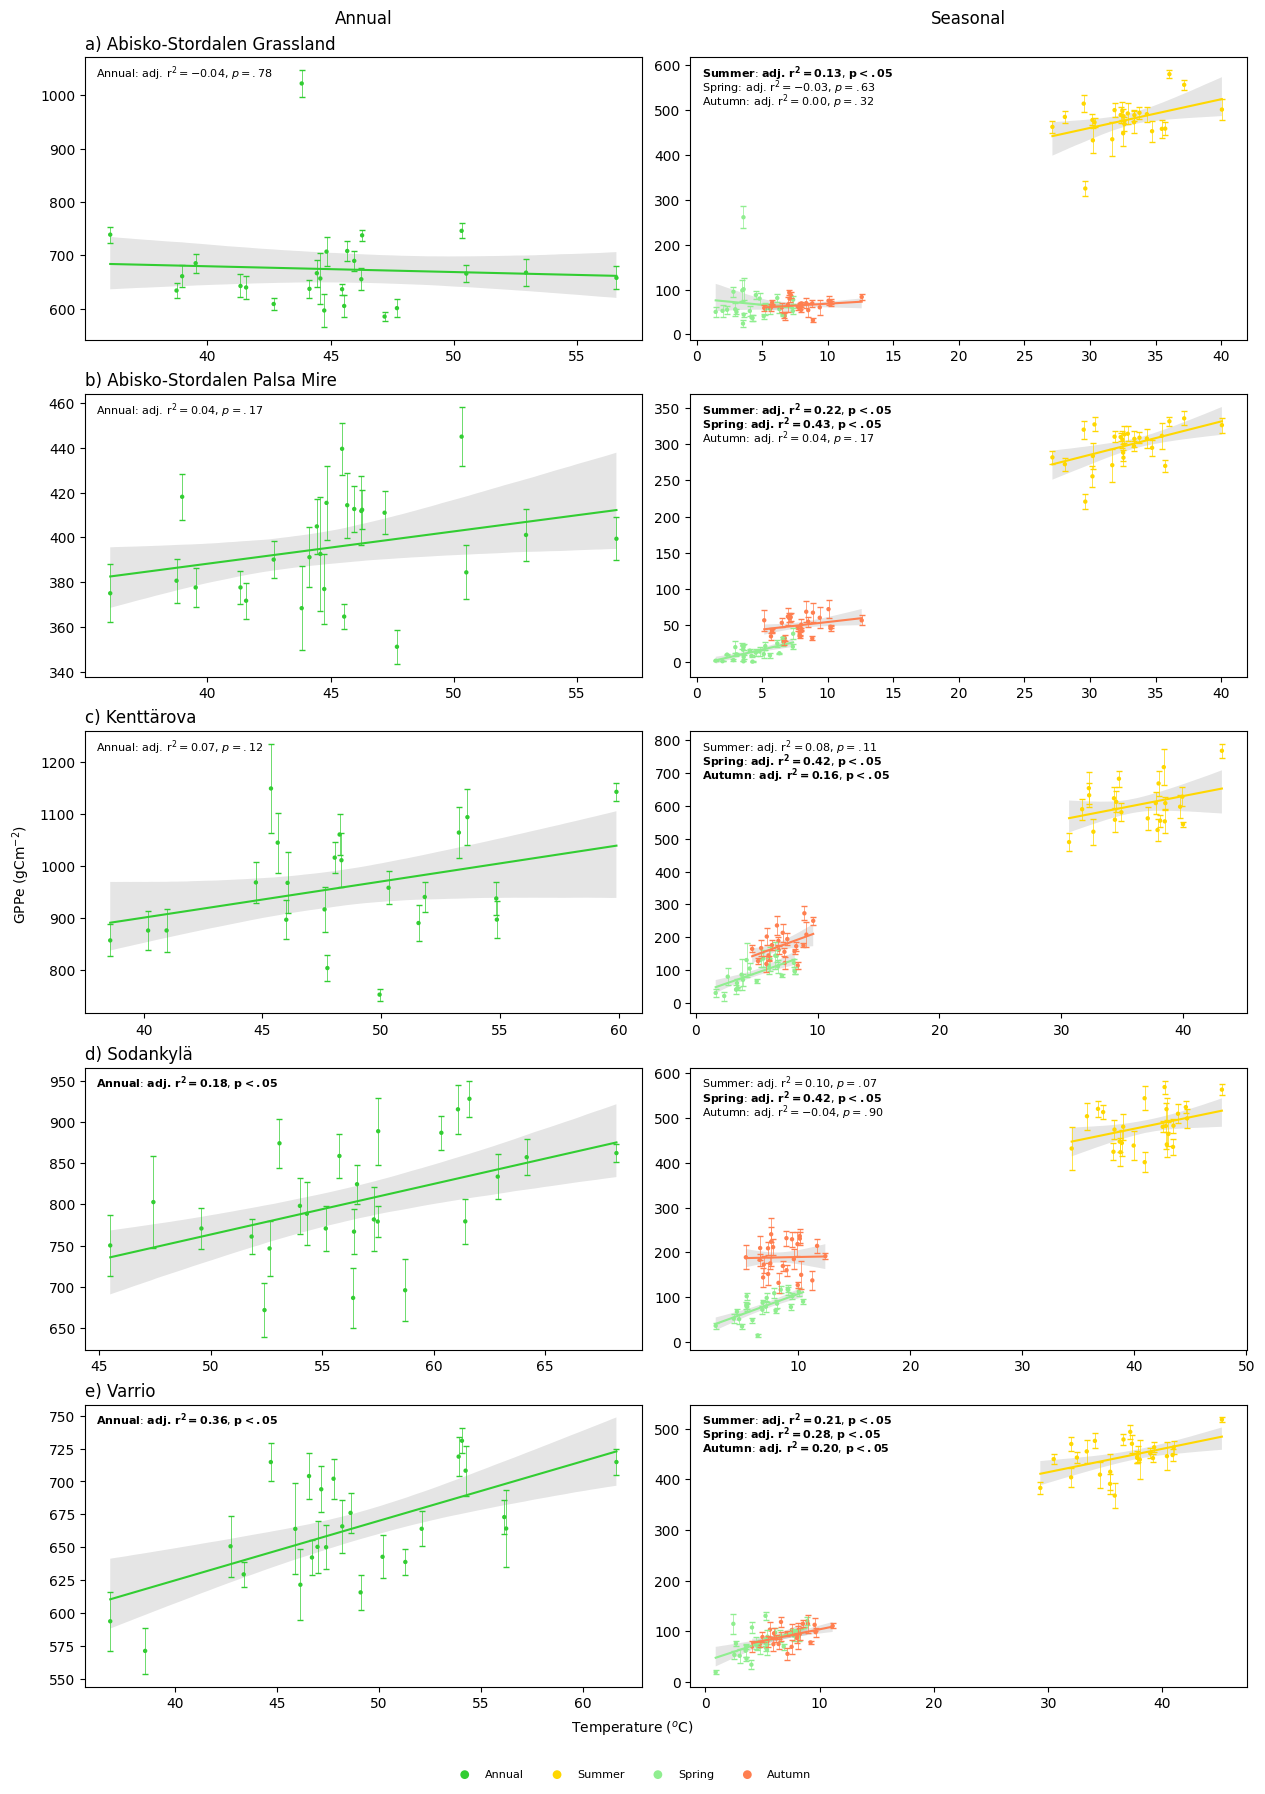

In [22]:
fig, ax = gen_fig(nrows = 5, ncols = 2, sharex = False, squish_factor = 2, flatten_ax = False)

# Left Column
test_name = "gppe-wi_annual"
for idx, (key, entry) in enumerate(stats_dict.items()):
    
    # Get Test Data and Results
    item = entry[test_name]
    
    ols_r2 = item["ols"].results.rsquared_adj
    ols_pval = item["ols"].results.pvalues[(item["x_var"]),].item() # get p value for the x var (as opposed to the constant)
    
    x_var = item["x_var"]
    y_var = item["y_var"]
    x = item["df"][item["x_var"]]
    y = item["df"][item["y_var"]]
    x_range = item["ols"].x_range
    y_pred = item["ols"].y_pred
    ci_lo = item["ols"].ci_lo
    ci_hi = item["ols"].ci_hi
    yerr = item["df"][item["y_var_std"]]
    
    # Plot
    ax[idx, 0].plot(
        x_range, y_pred,
        color = aes["colours"][y_var]
        )
    ax[idx, 0].fill_between(
        x_range.flatten(),
        ci_lo.flatten(), ci_hi.flatten(),
        color = "black", alpha = 0.1, edgecolor = "none"
    )
    ax[idx, 0].scatter(
        x, y,
        s = 10, edgecolor = "none",
        color = aes["colours"][y_var],
        label = "Annual"
        )
    ax[idx, 0].errorbar(
        x.squeeze(), y.squeeze(),
        yerr = yerr.squeeze(),
        fmt = "none",
        color = aes["colours"][y_var],
        elinewidth = 0.5, capsize = 2.5
    )
    
    # Stats Text
    write_stats(ax = ax, row = idx, col = 0, name = "Annual", ols = (ols_r2, ols_pval))
    
    # Pane Title
    ax[idx, 0].set_title(f"{chr(ord('`') + idx + 1)}) {aes["fluxnames"][key]}", loc = "left")

# Right Column  
test_name = "gppe-wi_season"
for idx, (key, entry) in enumerate(stats_dict.items()):
    ys = []
    for idx_season, (season, item) in enumerate(entry[test_name].items()):
        
        # Get Test Data and Results
        ols_r2 = item["ols"].results.rsquared_adj
        ols_pval = item["ols"].results.pvalues[(item["x_var"]),].item() # get p value for the x var (as opposed to the constant)
        
        x_var = item["x_var"]
        y_var = item["y_var"]
        x = item["df"][item["x_var"]]
        y = item["df"][item["y_var"]]
        x_range = item["ols"].x_range
        y_pred = item["ols"].y_pred
        ci_lo = item["ols"].ci_lo
        ci_hi = item["ols"].ci_hi
        yerr = item["df"][item["y_var_std"]]
        
        # Plot
        ax[idx, 1].plot(
            x_range, y_pred,
            color = aes["colours"]["seasons"][season]
            )
        ax[idx, 1].fill_between(
            x_range.flatten(),
            ci_lo.flatten(), ci_hi.flatten(),
            color = "black", alpha = 0.1, edgecolor = "none"
        )
        ax[idx, 1].scatter(
            x, y,
            s = 10, edgecolor = "none",
            color = aes["colours"]["seasons"][season],
            label = season.capitalize()
            )
        ax[idx, 1].errorbar(
            x.squeeze(), y.squeeze(),
            yerr = yerr.squeeze(),
            fmt = "none",
            elinewidth = 0.5, capsize = 2.5,
            color = aes["colours"]["seasons"][season]
        )
        
        # Stats Text
        write_stats(ax = ax, row = idx, col = 1, name = season.capitalize(), name_idx = idx_season, ols = (ols_r2, ols_pval))
        
        # Collect y values from each season and....
        ys.append(y)
        
    # ...set ylim of all seasons to give space for stats text
    #ax[idx][1].set_ylim(0, np.max(ys) + (np.max(ys)/5))
    
# Labels
fig.supylabel(f"{aes["varnames"][y_var]} {aes["units"][y_var]}", fontsize = 10) # just take the y_var from the last loop
fig.supxlabel(f"{aes["varnames"][x_var]} {aes["units"][x_var]}", fontsize = 10) # just take the y_var from the last loop
ax[0][0].text(x = 0.5, y = 1.12, s = "Annual", ha = "center", fontsize = 12, transform = ax[0][0].transAxes)
ax[0][1].text(x = 0.5, y = 1.12, s = "Seasonal", ha = "center", fontsize = 12, transform = ax[0][1].transAxes)

# Legend
add_outer_legend(fig = fig, ax = ax, ncol = 5)

# Save
save_fig(fig, "gppe-wi_annual&seasonal", bbox_inches_tight = True)

# GPPe WI Residuals Over Snowdepth

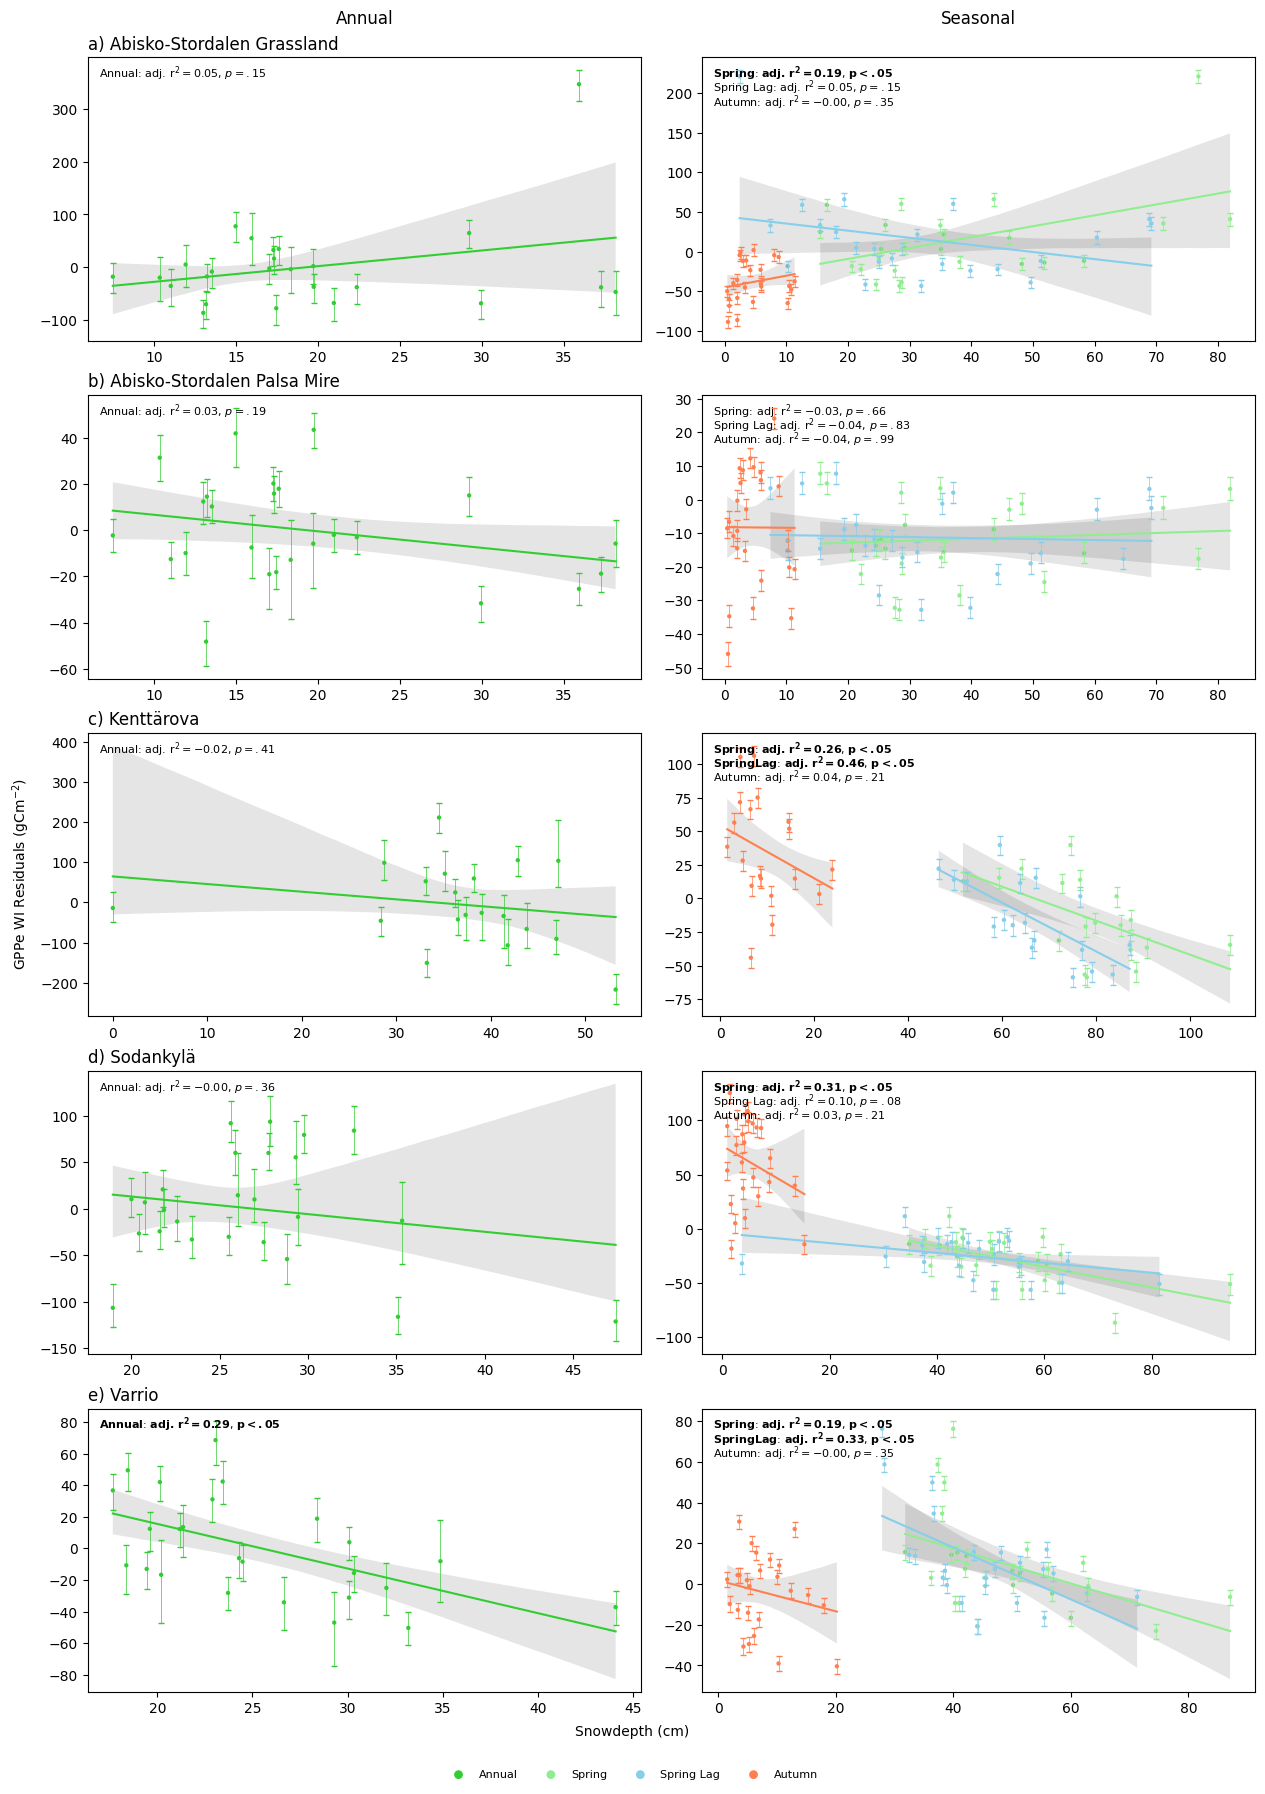

In [23]:
fig, ax = gen_fig(nrows = 5, ncols = 2, sharex = False, squish_factor = 2, flatten_ax = False)

# Left Column
test_name = "gppe-snow_annual"
for idx, (key, entry) in enumerate(stats_dict.items()):
    
    # Get Test Data and Results
    item = entry[test_name]
    
    ols_r2 = item["ols"].results.rsquared_adj
    ols_pval = item["ols"].results.pvalues[(item["x_var"]),].item() # get p value for the x var (as opposed to the constant)
    
    x_var = item["x_var"]
    y_var = item["y_var"]
    x = item["df"][item["x_var"]]
    y = item["df"][item["y_var"]]
    x_range = item["ols"].x_range
    y_pred = item["ols"].y_pred
    ci_lo = item["ols"].ci_lo
    ci_hi = item["ols"].ci_hi
    y_lo = item["df"][item["y_var_lo"]]
    y_hi = item["df"][item["y_var_hi"]]
    
    # Plot
    ax[idx, 0].plot(
        x_range, y_pred,
        color = aes["colours"][y_var]
        )
    ax[idx, 0].fill_between(
        x_range.flatten(),
        ci_lo.flatten(), ci_hi.flatten(),
        color = "black", alpha = 0.1, edgecolor = "none"
    )
    ax[idx, 0].scatter(
        x, y,
        s = 10, edgecolor = "none",
        color = aes["colours"][y_var],
        label = "Annual"
        )
    ax[idx, 0].errorbar(
        x.squeeze(), y.squeeze(),
        yerr = np.array([(y.values - y_lo.values).flatten(), (y_hi.values - y.values).flatten()]), # pandas cols are different names so cannot subract one anotger. so take values and then make back into pd.series
        fmt = "none",
        color = aes["colours"][y_var],
        elinewidth = 0.5, capsize = 2.5
    )
    
    # Stats Text
    write_stats(ax = ax, row = idx, col = 0, name = "Annual", ols = (ols_r2, ols_pval))
    
    # Pane Title
    ax[idx, 0].set_title(f"{chr(ord('`') + idx + 1)}) {aes["fluxnames"][key]}", loc = "left")

# Right Column  
test_name = "gppe-snow_season"
for idx, (key, entry) in enumerate(stats_dict.items()):
    ys = []
    for idx_season, (season, item) in enumerate(entry[test_name].items()):
        
        # Get Test Data and Results
        ols_r2 = item["ols"].results.rsquared_adj
        ols_pval = item["ols"].results.pvalues[(item["x_var"]),].item() # get p value for the x var (as opposed to the constant)
        
        x_var = item["x_var"]
        y_var = item["y_var"]
        x = item["df"][item["x_var"]]
        y = item["df"][item["y_var"]]
        x_range = item["ols"].x_range
        y_pred = item["ols"].y_pred
        ci_lo = item["ols"].ci_lo
        ci_hi = item["ols"].ci_hi
        y_lo = item["df"][item["y_var_lo"]]
        y_hi = item["df"][item["y_var_hi"]]
            
        # Plot
        ax[idx, 1].plot(
            x_range, y_pred,
            color = aes["colours"]["seasons"][season]
            )
        ax[idx, 1].fill_between(
            x_range.flatten(),
            ci_lo.flatten(), ci_hi.flatten(),
            color = "black", alpha = 0.1, edgecolor = "none"
        )
        ax[idx, 1].scatter(
            x, y,
            s = 10, edgecolor = "none",
            color = aes["colours"]["seasons"][season],
            label = season.title()
            )
        ax[idx, 1].errorbar(
            x.squeeze(), y.squeeze(),
            yerr = np.array([(y.values - y_lo.values).flatten(), (y_hi.values - y.values).flatten()]),
            fmt = "none",
            elinewidth = 0.5, capsize = 2.5,
            color = aes["colours"]["seasons"][season]
        )
        
        # Stats Text
        write_stats(ax = ax, row = idx, col = 1, name = season.title(), name_idx = idx_season, ols = (ols_r2, ols_pval))
        
        # Collect y values from each season and....
        ys.append(y)
        
    # ...set ylim of all seasons to give space for stats text
    #ax[idx][1].set_ylim(0, np.max(ys) + (np.max(ys)/5))
    
# Labels
fig.supylabel(f"{aes["varnames"][y_var]} WI Residuals {aes["units"][y_var]}", fontsize = 10) # just take the y_var from the last loop
fig.supxlabel(f"{aes["varnames"][x_var]} {aes["units"][x_var]}", fontsize = 10) # just take the y_var from the last loop
ax[0][0].text(x = 0.5, y = 1.12, s = "Annual", ha = "center", fontsize = 12, transform = ax[0][0].transAxes)
ax[0][1].text(x = 0.5, y = 1.12, s = "Seasonal", ha = "center", fontsize = 12, transform = ax[0][1].transAxes)

# Legend
add_outer_legend(fig = fig, ax = ax, ncol = 5)

# Save
save_fig(fig, "gppe-snow_annual&seasonal", bbox_inches_tight = True)